# process spectra for AuxTel with new spectractor (version=2.5, July 2023, branch  master)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : August 27th 2023
- update : 2023-08-27 

- version v6 : Work with extr

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with the new kernel **miniconda3_py310_auxtel** (with stackyter.py) 
- works with the new kernel **miniconda3_py38_auxtel** (with notebook.cc.in2p3.fr) 


# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/Volumes/Backup2020/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_08', '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python39.zip', '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9', '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/lib-dynload', '', '/Users/dagoret/.local/lib/python3.9/site-packages', '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages', '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/Spectractor-2.5-py3.9.egg']


In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.10/site-packages','/pbs/home/d/dagoret/.local/lib/python3.10/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [4]:
sys.path

['/Volumes/Backup2020/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_08',
 '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python39.zip',
 '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9',
 '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/lib-dynload',
 '',
 '/Users/dagoret/.local/lib/python3.9/site-packages',
 '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages',
 '/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/Spectractor-2.5-py3.9.egg']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/dagoret/opt/anaconda3/envs/spectractor/bin/python
3.9.17 | packaged by conda-forge | (main, Aug 10 2023, 07:05:25) 
[Clang 15.0.7 ]
sys.version_info(major=3, minor=9, micro=17, releaselevel='final', serial=0)


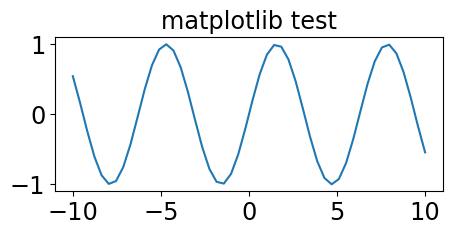

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.title("matplotlib test")
plt.show()


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.24.0'

In [10]:
import scipy
print(scipy.__version__)

1.11.2


In [11]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters
#dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [12]:
import logging

In [13]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [14]:
from distutils.dir_util import copy_tree
import shutil

In [15]:
from astroquery.simbad import Simbad
import astroquery
astroquery.__version__
result_table = Simbad.query_object("M1")

In [16]:
def find_target_name(tag):
    try:
        target_name=tag
        result_table = Simbad.query_object(target_name)
        return target_name
    except:
        target_name_stripped = ''.join(tag.split())
        result_table = Simbad.query_object(target_name_stripped)
        return target_name_stripped 
           

# Configuration

## Logger

In [17]:
my_logger = logging

## Config for the notebook

In [18]:
version="v6.0"  # version for taking images from data/2023 (images come from usdf)
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [19]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini', 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini']


In [20]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini']

config_idx = len(list_of_spectractorconfigfiles)-2
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [21]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini'

In [22]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [23]:
! pwd

/Volumes/Backup2020/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_08


In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [25]:
load_config(configfilename)

In [26]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR ../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR extractor/dispersers/
DISPLAY True
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
LAMBDAS [ 300  301  302  303  304  305  306  307  308  309  310  311  312  313
  314  315  316  317  318  319  320  321  322  323  324  325  326  327
  328  329  330  331  332  333  334  335  336  337  338  339  340  341
  342  343  344  345  346  347  348  349  350  351  352  353  354  355
  356  357  358  359  360  361  362  363  364  365  366  367  368  369
  370  371  372  373  374  375  376  377  378  379  380  381  382  383
  384  385  386  387  388  389  390  391  392  393  394  395  396  397
  39

# Exposure config

In [27]:
! ls logbooks

auxtellogbook_empty~holo4_003_20230718_v6.0.csv
auxtellogbook_empty~holo4_003_20230718_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230720_v6.0.csv
auxtellogbook_empty~holo4_003_20230720_v6.0.xlsx


In [28]:
# path index for each month
DATE="20230720"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [29]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [30]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=False
LAPTOP=True

In [31]:
def GetPaths(computer_name):
    """
    """
    
    if computer_name == "HOSTCC":
        
        path_auxtel="/sps/lsst/groups/auxtel"
        path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
    
        path_images=os.path.join(path_auxtel,"data/hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
    elif computer_name == "LAPTOP1":
        path_auxtel="/Users/dagoret/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
        
    elif computer_name == "WORKIMAC":
        path_auxtel="/Users/sylvie/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
            
            
        
    elif computer_name == "HOMEIMAC":
        path_auxtel="/Volumes/Backup2020/DATA"
        path_spectractor=os.path.join(path_auxtel,"MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(".","config")
        path_images=os.path.join(path_auxtel,"hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        
        # /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor
        
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode)
            
        
    else:
        print(f"Unknown computer {computer_name}")
        
              
    return path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor
        

In [32]:
!ls /Volumes/Backup2020/DATA/

AuxTelDATA2023   AuxTelData2021   ExtractedSpectra hack_usdf


In [33]:
mycomputer_name = "HOMEIMAC"
path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor  = GetPaths(mycomputer_name)

In [34]:
path_images

'/Volumes/Backup2020/DATA/hack_usdf/my_postisrccd_img_forspectractor_2023/empty~holo4_003/20230720'

In [35]:
path_topoutput_spectractor

'/Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [36]:
path_output_spectractor

'/Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230720'

# Utility Functions

In [37]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [38]:
!ls logbooks

auxtellogbook_empty~holo4_003_20230718_v6.0.csv
auxtellogbook_empty~holo4_003_20230718_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230720_v6.0.csv
auxtellogbook_empty~holo4_003_20230720_v6.0.xlsx


In [39]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [40]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_003_20230720_v6.0.csv'

In [41]:
df=pd.read_csv(filename_logbook,index_col=0)

In [42]:
pd.set_option('display.max_rows', None)

In [43]:
# show the list of input files from the logbook to select the file index in the logbook
df

index                     date  \
0       0  2023-07-21T02:06:41.809   
1       1  2023-07-21T02:08:28.797   
2       2  2023-07-21T02:09:11.855   
3       3  2023-07-21T02:14:23.522   
4       4  2023-07-21T02:15:06.540   
5       5  2023-07-21T02:35:45.995   
6       6  2023-07-21T02:36:29.007   
7       7  2023-07-21T02:37:47.189   
8       8  2023-07-21T02:38:30.397   
9       9  2023-07-21T02:46:24.590   
10     10  2023-07-21T02:47:07.568   
11     11  2023-07-21T03:25:50.487   
12     12  2023-07-21T03:26:33.517   
13     13  2023-07-21T03:27:54.920   
14     14  2023-07-21T03:28:37.935   
15     15  2023-07-21T03:33:49.285   
16     16  2023-07-21T03:34:32.276   
17     17  2023-07-21T04:10:28.900   
18     18  2023-07-21T04:11:11.916   
19     19  2023-07-21T04:12:31.651   
20     20  2023-07-21T04:13:14.614   

                                                 path  \
0   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
1   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
2   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
3   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
4   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
5   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
6   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
7   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
8   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
9   /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
10  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
11  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
12  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
13  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
14  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
15  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
16  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
17  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
18  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
19  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   
20  /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...   

                                             file  num    object   filter  \
0   exposure_2023072000235_pseudo-postisrccd.fits  235  HD146233  empty_1   
1   exposure_2023072000238_pseudo-postisrccd.fits  238  HD146233  empty_1   
2   exposure_2023072000239_pseudo-postisrccd.fits  239  HD146233  empty_1   
3   exposure_2023072000248_pseudo-postisrccd.fits  248  HD146233  empty_1   
4   exposure_2023072000249_pseudo-postisrccd.fits  249  HD146233  empty_1   
5   exposure_2023072000253_pseudo-postisrccd.fits  253  HD185975  empty_1   
6   exposure_2023072000254_pseudo-postisrccd.fits  254  HD185975  empty_1   
7   exposure_2023072000256_pseudo-postisrccd.fits  256  HD185975  empty_1   
8   exposure_2023072000257_pseudo-postisrccd.fits  257  HD185975  empty_1   
9   exposure_2023072000266_pseudo-postisrccd.fits  266  HD146233  empty_1   
10  exposure_2023072000267_pseudo-postisrccd.fits  267  HD146233  empty_1   
11  exposure_2023072000270_pseudo-postisrccd.fits  270  HD146233  empty_1   
12  exposure_2023072000271_pseudo-postisrccd.fits  271  HD146233  empty_1   
13  exposure_2023072000273_pseudo-postisrccd.fits  273  HD146233  empty_1   
14  exposure_2023072000274_pseudo-postisrccd.fits  274  HD146233  empty_1   
15  exposure_2023072000283_pseudo-postisrccd.fits  283  HD146233  empty_1   
16  exposure_2023072000284_pseudo-postisrccd.fits  284  HD146233  empty_1   
17  exposure_2023072000311_pseudo-postisrccd.fits  311  HD146233  empty_1   
18  exposure_2023072000312_pseudo-postisrccd.fits  312  HD146233  empty_1   
19  exposure_2023072000314_pseudo-postisrccd.fits  314  HD146233  empty_1   
20  exposure_2023072000315_pseudo-postisrccd.fits  315  HD146233  empty_1   

    disperser   airmass  exposure  ...  temperature  humidity  windspd  \
0   holo4_003  1.111735      30.0  ...      10.3250    8.7500   9.0072   
1   holo4_003  1.113877      30.0  ...      10.0750    9.4250   6.922

# Selection of input file
- the input file is selected from the logbook list above

In [44]:
idx = 0

In [45]:
print(df.iloc[idx]['file'])

exposure_2023072000235_pseudo-postisrccd.fits


In [46]:
print(df.iloc[idx])

index                                                          0
date                                     2023-07-21T02:06:41.809
path           /Volumes/Backup2020/DATA/hack_usdf/my_postisrc...
file               exposure_2023072000235_pseudo-postisrccd.fits
num                                                          235
object                                                  HD146233
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.111735
exposure                                                    30.0
focus                                                  -0.016626
seeing                                                      1.15
pressure                                                 77684.0
temperature                                               10.325
humidity                                                    8.75
windspd                  

In [47]:
the_num = df.iloc[idx]["num"]

In [48]:
myhome=os.getenv("HOME")

In [49]:
dir_images=path_images

In [50]:
dir_images

'/Volumes/Backup2020/DATA/hack_usdf/my_postisrccd_img_forspectractor_2023/empty~holo4_003/20230720'

In [51]:
filename_image=df['file'][idx]
filename_image

'exposure_2023072000235_pseudo-postisrccd.fits'

In [52]:
target = df['object'][idx]
target

'HD146233'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [53]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [54]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [55]:
path_output_spectractor

'/Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230720'

In [56]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [57]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
    
if configdir =="":
    output_directory="./outputs_process_" + DATE  + '_' + dispersername +'_nb_' + str(idx+1)
    output_figures="figures_process_" + DATE + '_' + dispersername + '_nb_' + str(idx+1)
else:
    output_directory = "./outputs_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    output_figures   = "./figures_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    
    

#guess = [300,1700]
guess = [350,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [58]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230720/2023072000235
output_directory = ./outputs_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1
output_figures = ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [59]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [60]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
    
# manage subdirs spectrum/ and plots/

if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [61]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [62]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [63]:
target_name_sel0 = find_target_name(target)
print(f"target_name_sel0 = {target_name_sel0}")
#target_name_sel0 = ''.join(target.split())
#target_name_sel1 = target_name_sel0.encode(encoding='UTF-8',errors='strict')
#target_name_sel = target_name_sel0.encode()
target_name_sel = target_name_sel0.encode(encoding="ascii", errors="ignore")
print(f'target_name_sel = {target_name_sel}')
#target_name_sel=f"{target_name_sel}"

target_name_sel0 = HD146233
target_name_sel = b'HD146233'


## Load the image in the new image file with Spectractor

In [64]:
if target_name_sel == 'MU-COL':
    target_name_sel = "HD38666"

In [65]:
%matplotlib inline
image=Image(file_name=filename, disperser_label=disperser_label,target_label=target_name_sel, config=config)

2023-08-28 10:58:19  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=4.247423388034187 but average of self.read_out_noise is 8.5.


In [66]:
!ls /Volumes/Backup2020/DATA/

AuxTelDATA2023   AuxTelData2021   ExtractedSpectra hack_usdf


In [67]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [68]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [69]:
image.header["FILTER"]

'empty_1'

In [70]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
DETSIZE = '[1:4072,1:4000]'                                                     
BINX    =                    1                                                  
BINY    =                    1                                                  
CCDGAIN =                  1.0                                                  
CCDNOISE=                 10.0                                                  
CCDSLOT = 'S00     '                                                            
RAFTBAY = 'R00     '        

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

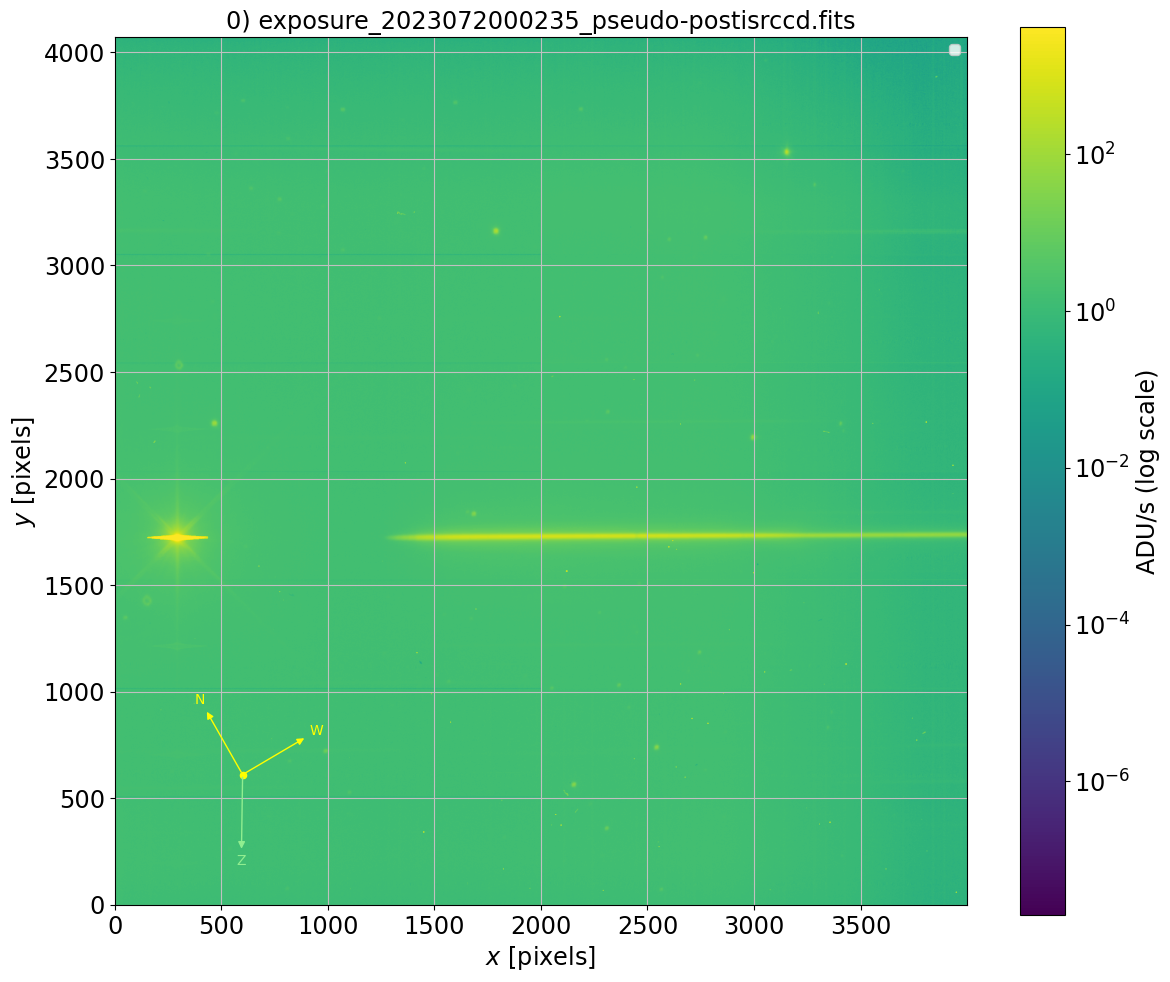

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)
plt.show()

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [72]:
filename_image

'exposure_2023072000235_pseudo-postisrccd.fits'

## Let Spectractor find the location of the 0th order

2023-08-28 10:58:31  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ------------------ -------------------- --------------------
    16.662846715727905 -0.08428828020704732 0.031907072474448406
2023-08-28 10:58:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 17 iterations because the relative change of cost is below ftol=1.25e-05.


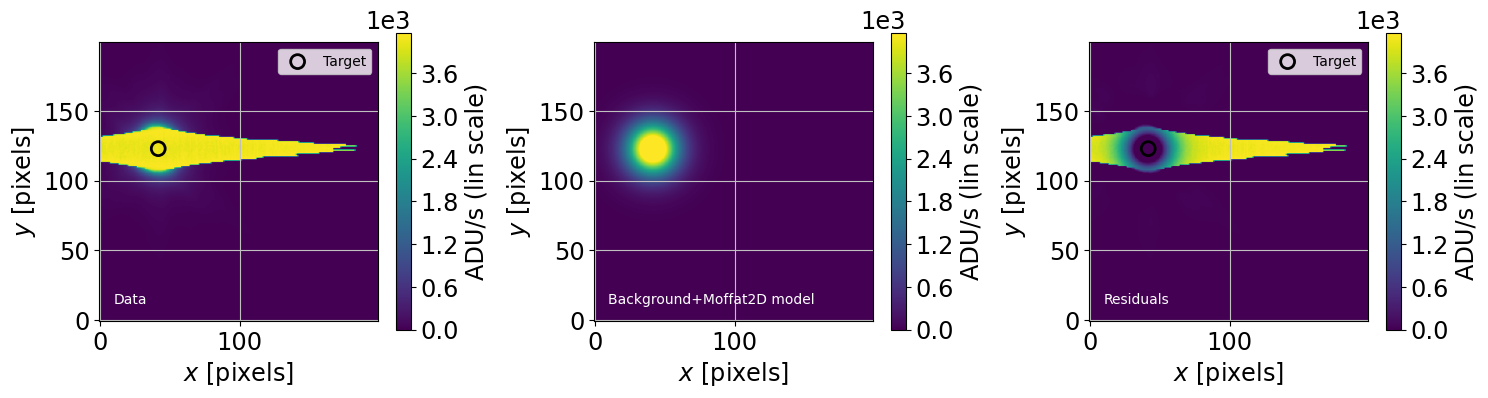

2023-08-28 10:58:34  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5.4945054945054945e-05.


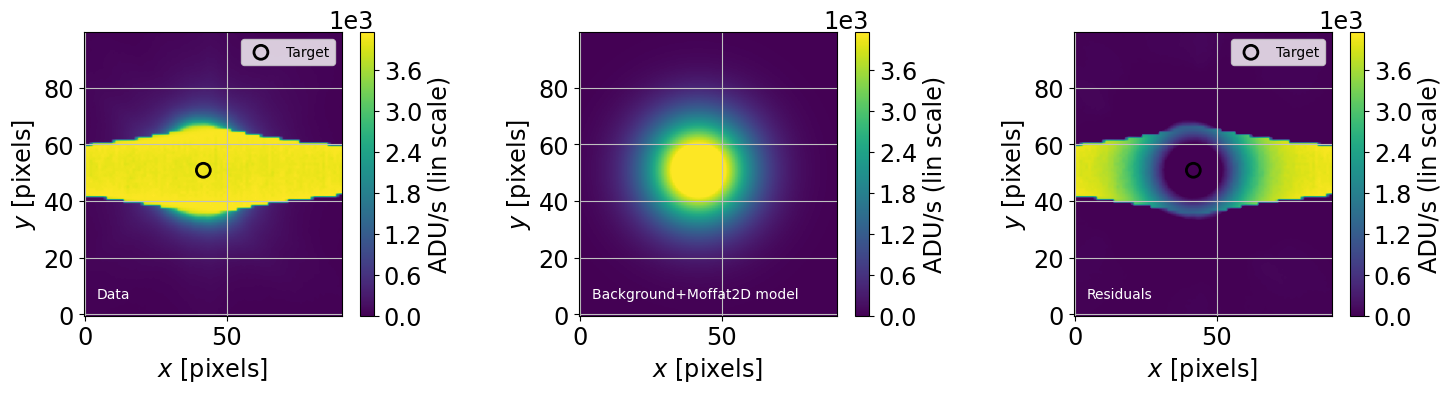

In [73]:
parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [74]:
print(x1,y1)

291.6662907218734 1722.8473322756868


## Check the location of 0th order and Analysis of the quality of its focus

In [75]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [76]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [77]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [78]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [79]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [80]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [81]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [82]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [83]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [84]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [85]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [86]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [87]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.5, 0.98, '0) exposure_2023072000235_pseudo-postisrccd.fits')

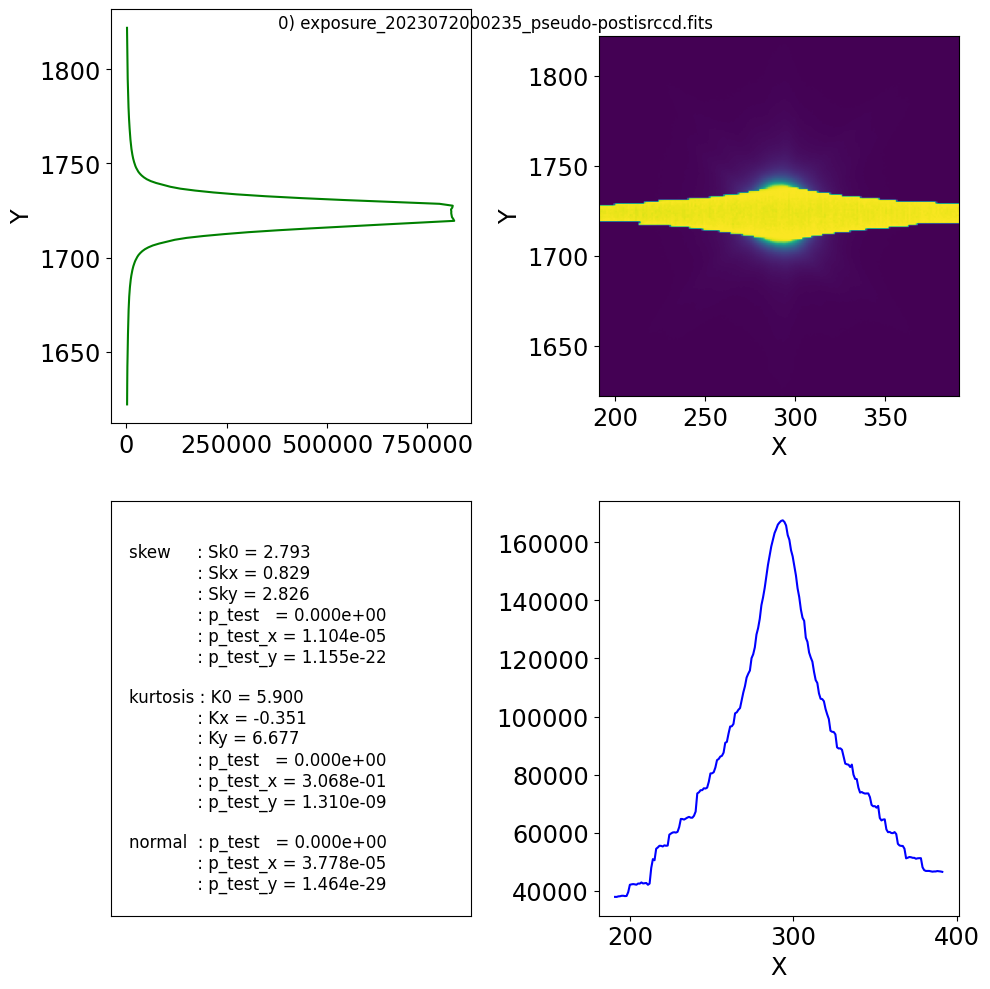

In [88]:
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [89]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [90]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [91]:
filename

'/Volumes/Backup2020/DATA/hack_usdf/my_postisrccd_img_forspectractor_2023/empty~holo4_003/20230720/exposure_2023072000235_pseudo-postisrccd.fits'

In [92]:
output_directory

'./outputs_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1'

2023-08-28 10:58:37  spectractor.extractor.extractor SpectractorInit      INFO   
	Spectractor initialisation
2023-08-28 10:58:37  spectractor.config load_config          INFO   
	Loading ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini with parameters.VERBOSE=True...
2023-08-28 10:58:37  spectractor.config load_config          INFO   Loaded ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini with
Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTIO

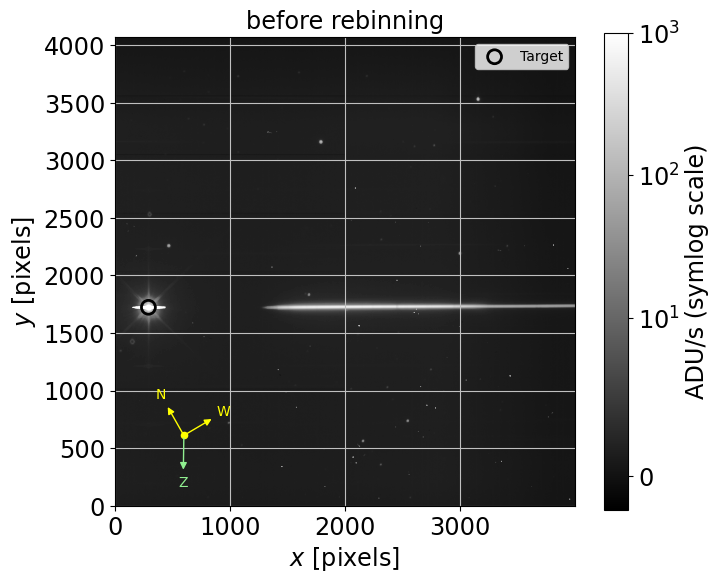

2023-08-28 10:58:54  spectractor.extractor.extractor SpectractorRun       INFO   
	  ======================= REBIN =============================


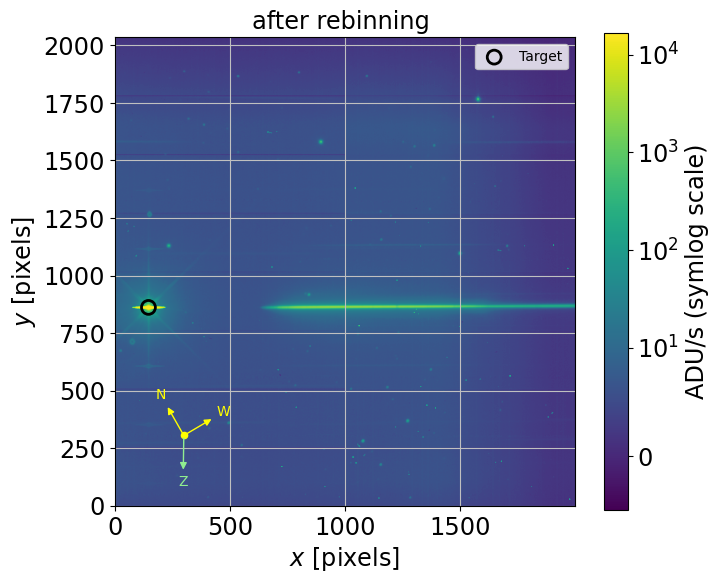

2023-08-28 10:58:58  spectractor.extractor.extractor SpectractorRun       INFO   
	Search for the target in the image with guess=[145.83314536 861.42366614]...
2023-08-28 10:58:58  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                 c0_1        
    ----------------- -------------------- --------------------
    53.85899475411047 0.037133160429195844 -0.03367318644297966
2023-08-28 10:58:58  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 14 iterations because the relative change of cost is below ftol=5e-05.


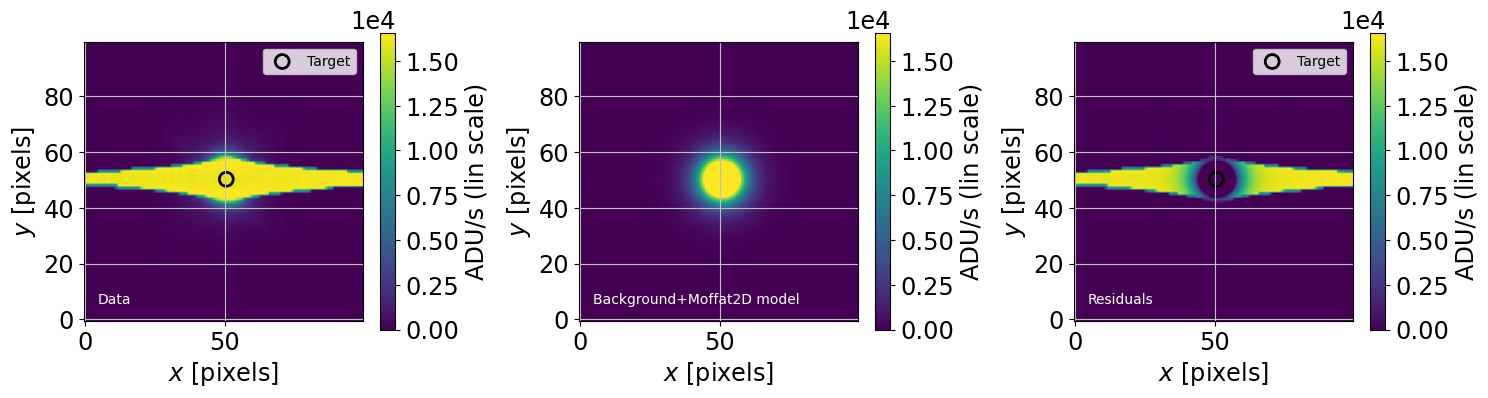

2023-08-28 10:58:59  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=0.0002.


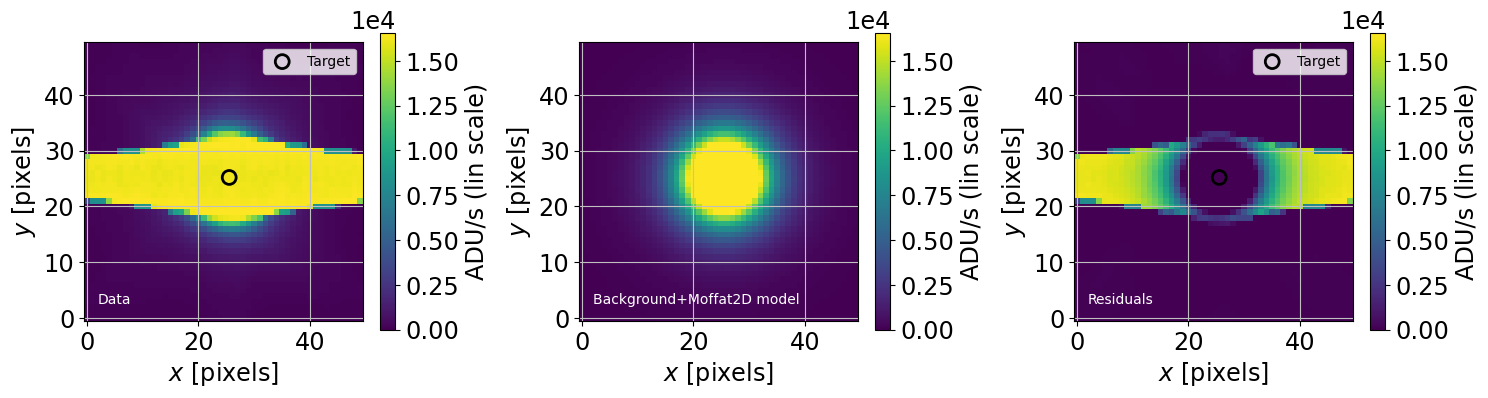

2023-08-28 10:59:00  Image      find_target          INFO   
	X,Y target position in pixels: 145.523,861.179
2023-08-28 10:59:00  Image      turn_image           INFO   
	Rotate the image with angle theta=0.20 degree from method disperser.


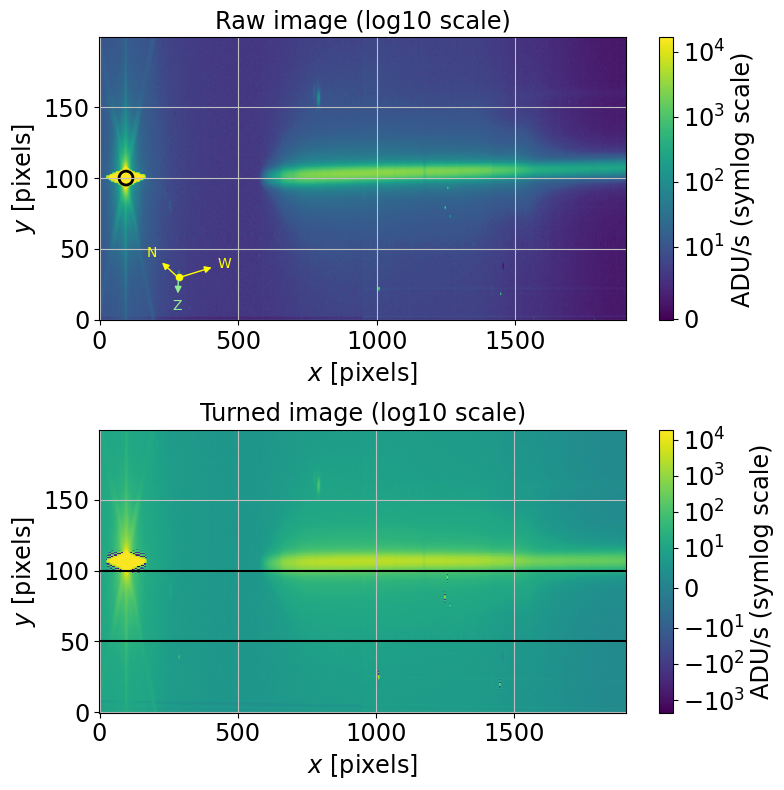

2023-08-28 10:59:04  spectractor.extractor.extractor SpectractorRun       INFO   
	Search for the target in the rotated image...
2023-08-28 10:59:04  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0               c0_1      
    ------------------ ------------------ -----------------
    3560.4723757752577 10.298878356166005 23.96301271455082
2023-08-28 10:59:04  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 7 iterations because the relative change of cost is below ftol=0.0002.
2023-08-28 10:59:04  Image      find_target_Moffat2D WARNING 
	X=35.45, Y=23.38 target position determination probably wrong: 10.2 pixels from profile detection (25.45, 25.58)


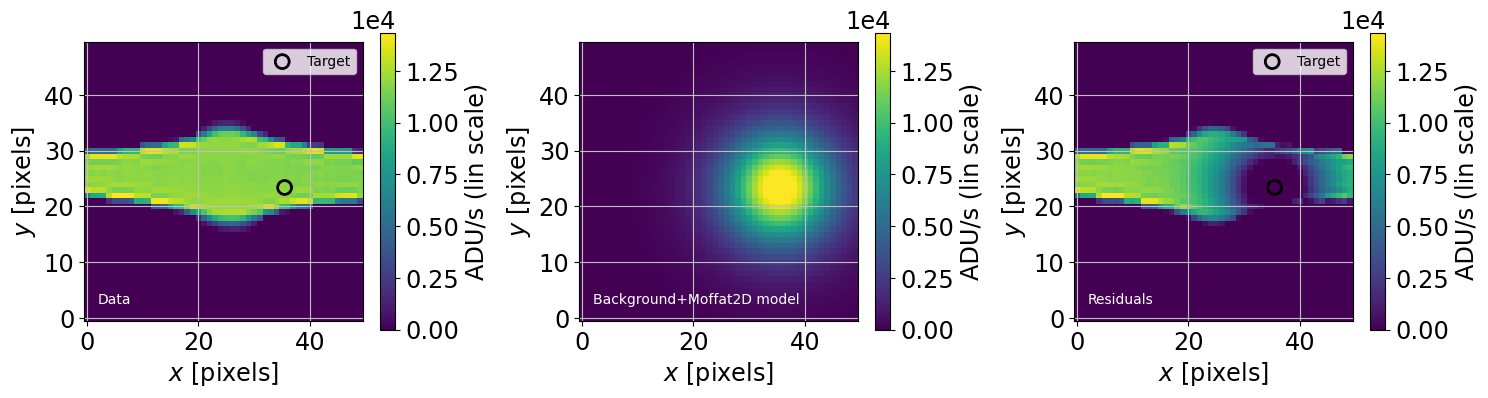

2023-08-28 10:59:05  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0008680555555555555.
2023-08-28 10:59:05  Image      find_target_Moffat2D WARNING 
	X=11.86, Y=12.58 target position determination probably wrong: 5.7 pixels from profile detection (6.49, 14.47)


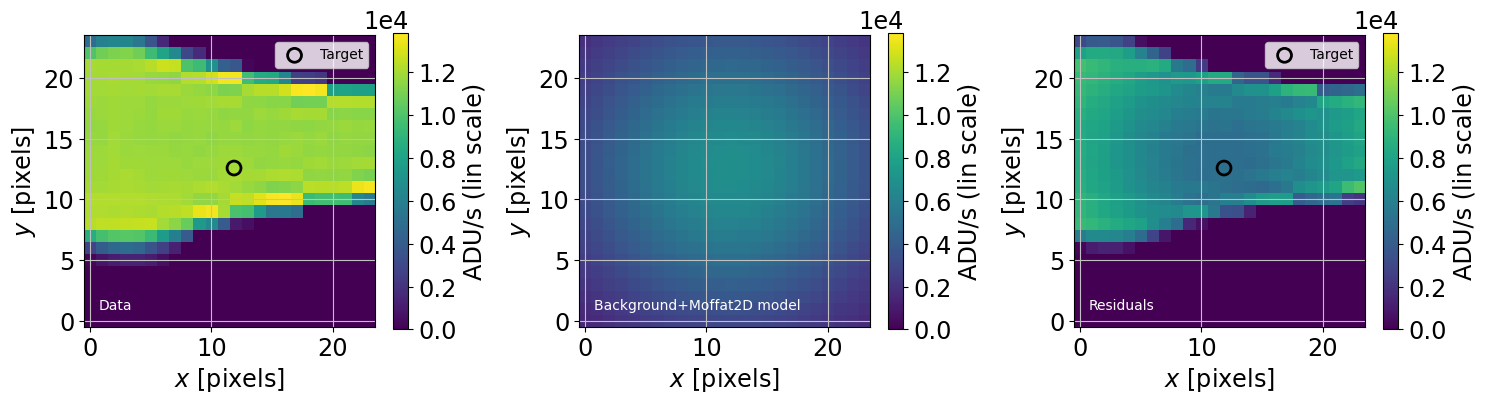

2023-08-28 10:59:06  Image      find_target          INFO   
	X,Y target position in pixels: 157.860,865.576
2023-08-28 10:59:06  Spectrum   __init__             INFO   
	Spectrum info copied from image
2023-08-28 10:59:06  spectractor.extractor.extractor SpectractorRun       INFO   
	 ======================== PSF1D Extraction ====================================
2023-08-28 10:59:06  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= extract_spectrum_from_image =============================
2023-08-28 10:59:06  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*10 pixels and background from 70 to 90 pixels
2023-08-28 10:59:06  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [577:1713,775:955] (size (1136, 180))


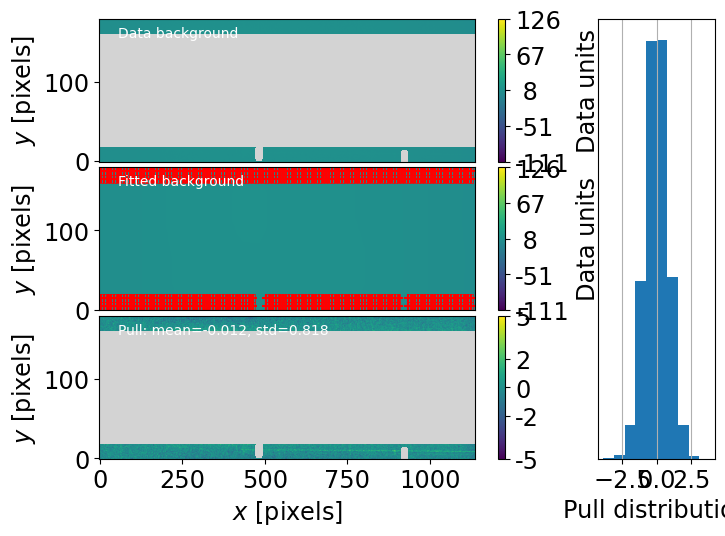

2023-08-28 10:59:07  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Fit the transverse profile =============================
2023-08-28 10:59:07  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


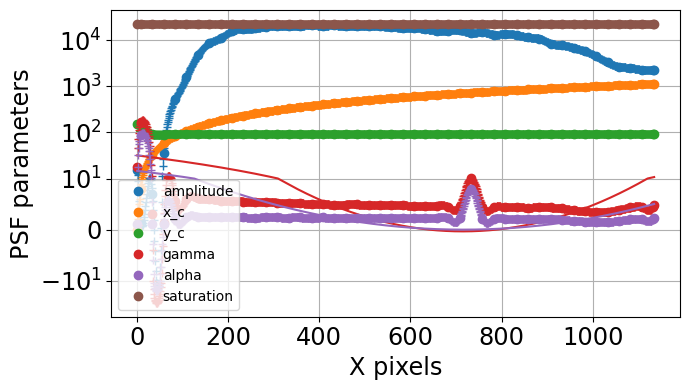

2023-08-28 10:59:10  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=2.3088e+06	initial chisq_red=101.62
2023-08-28 10:59:10  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	final cost=1.6725e+06	final chisq_red=73.615 	computed in 0.41s
2023-08-28 10:59:11  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1:	final cost=1.5838e+06	final chisq_red=69.709 	computed in 0.44s
2023-08-28 10:59:11  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=2:	final cost=1.5797e+06	final chisq_red=69.528 	computed in 0.39s
2023-08-28 10:59:12  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=3:	final cost=1.5796e+06	final chisq_red=69.524 	computed in 0.39s
2023-08-28 10:59:12  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=4:	final cost=1.5796e+06	final chisq_red=69.523 	computed in 0.39s
2023-08-28 10:59:12  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 it

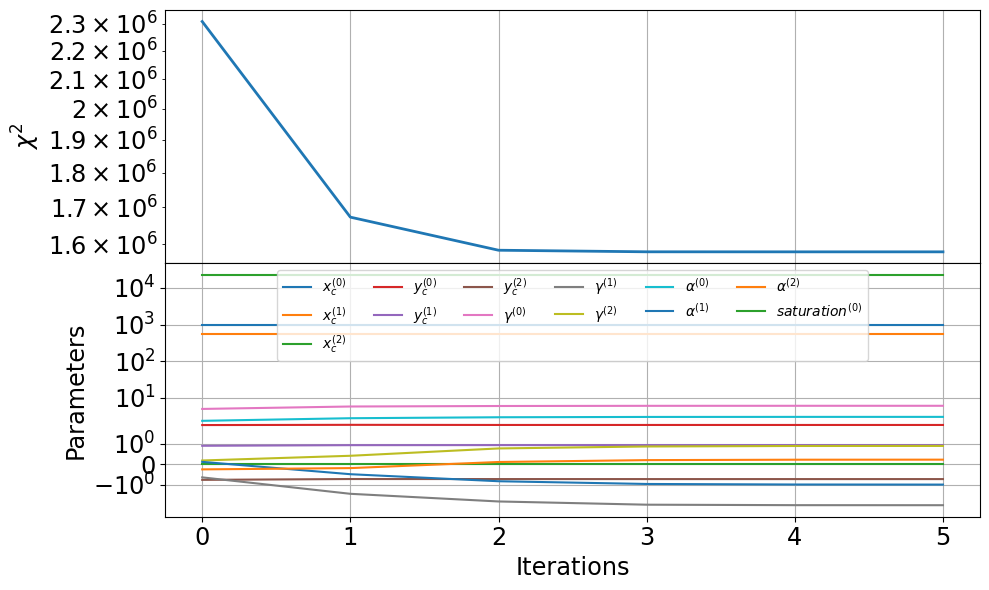

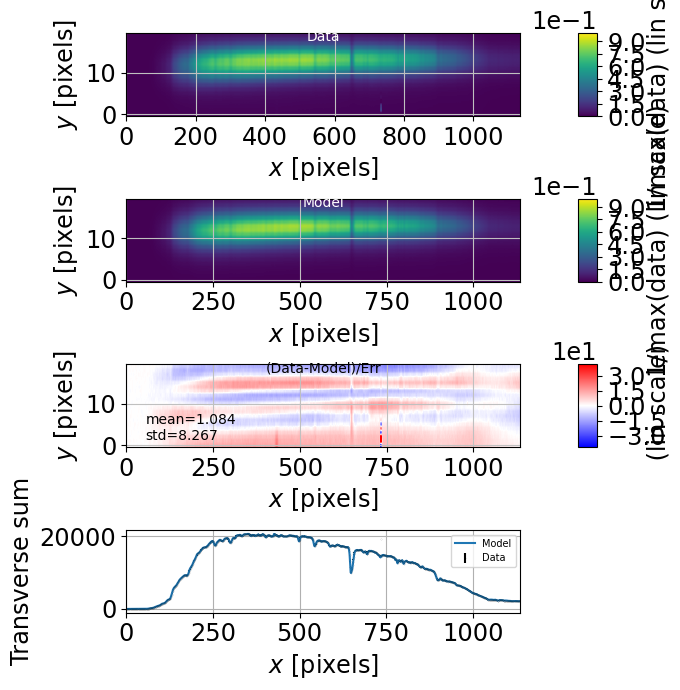

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:470: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


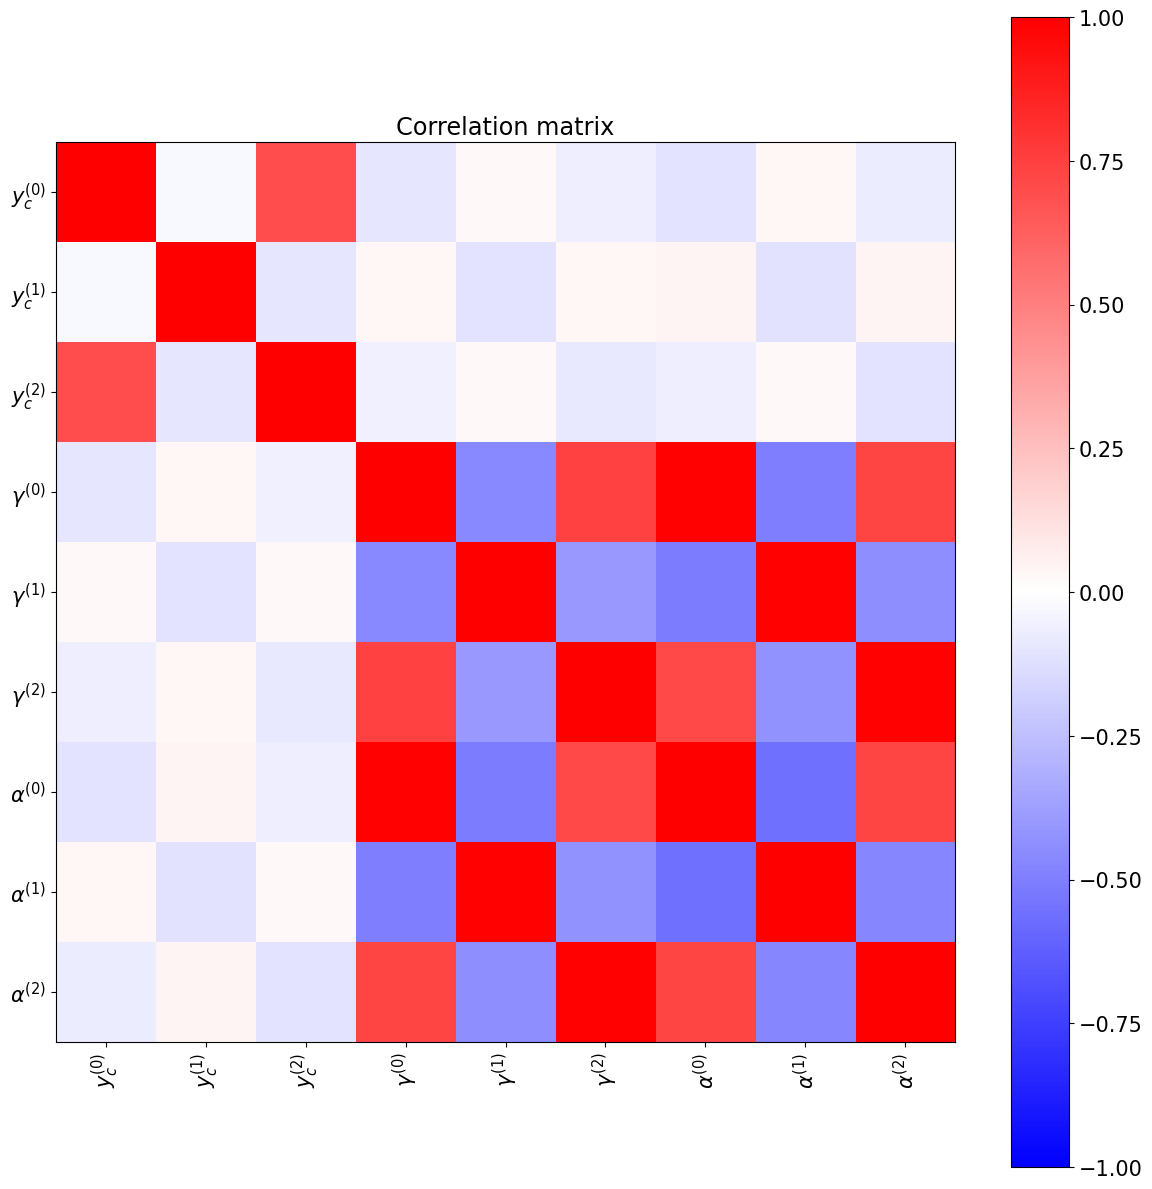

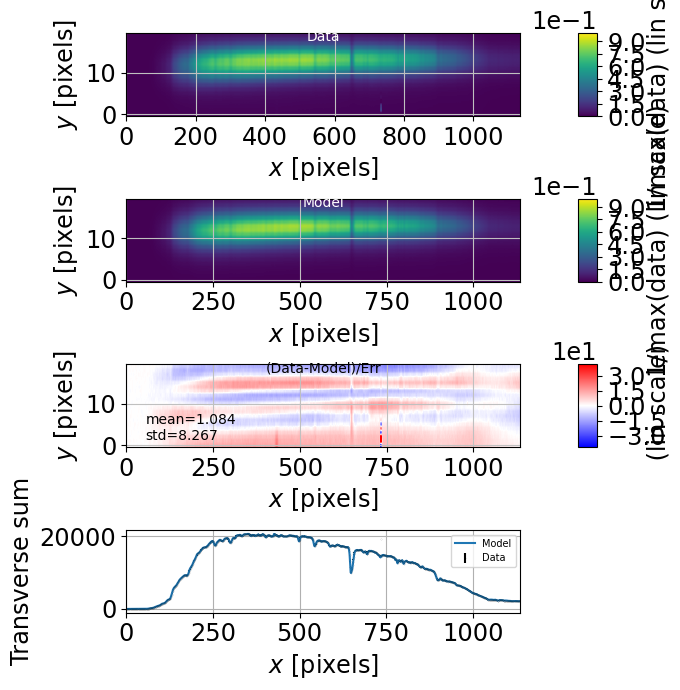

2023-08-28 10:59:18  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop raw image [564:1700,772:957] (size (1136, 185))
2023-08-28 10:59:18  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Extract the non rotated background  =============================


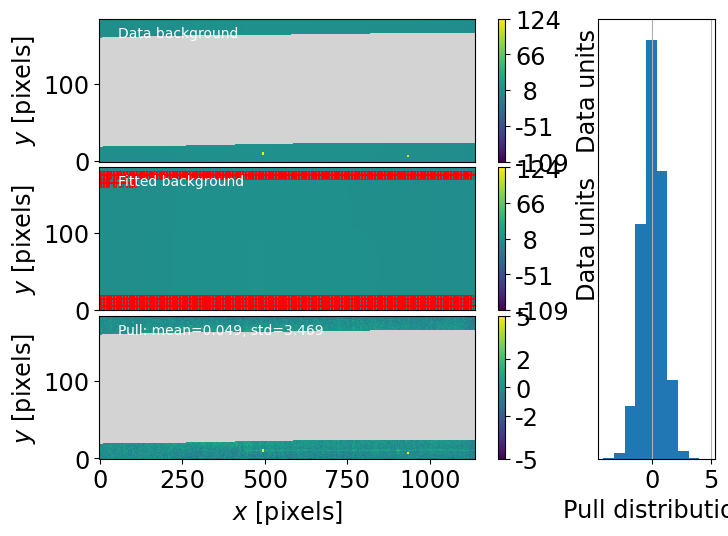

2023-08-28 10:59:19  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=7.324 ADU/s, RMS=0.599 ADU/s.
2023-08-28 10:59:19  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= first guess for lambdas  =============================
2023-08-28 10:59:19  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [564:1700,772:957] (size (1136, 185))
	New target position in spectrogram frame: [-418.4771647094228, 89.17875318864606]


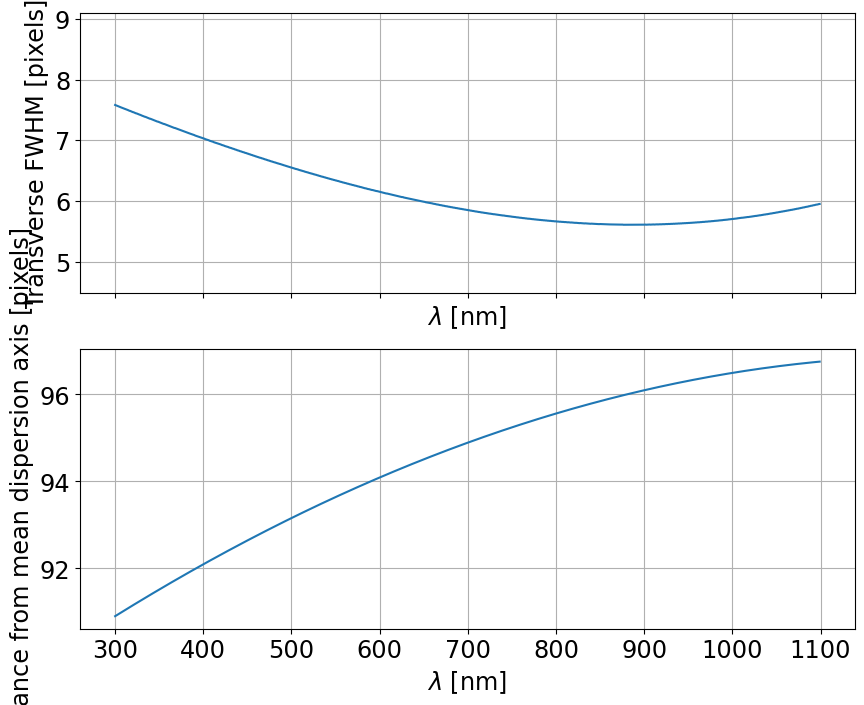

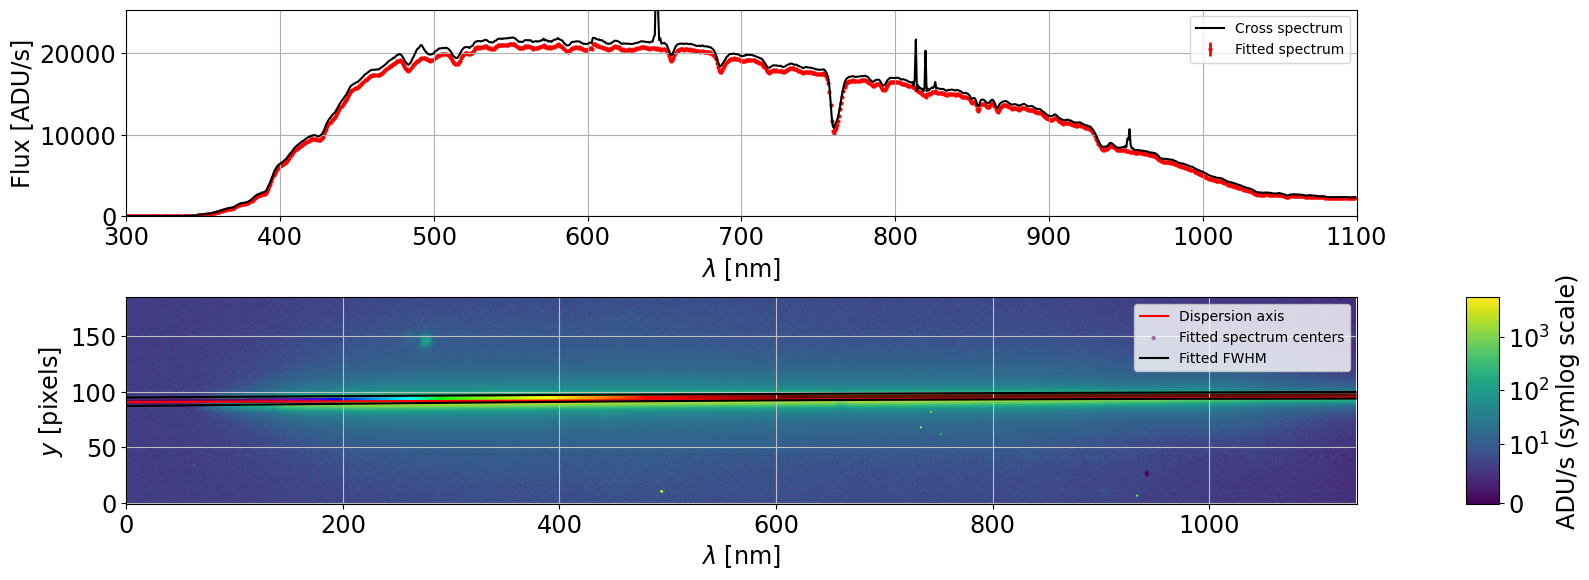

2023-08-28 10:59:21  spectractor.extractor.extractor SpectractorRun       INFO   
	Calibrating order 1 spectrum...


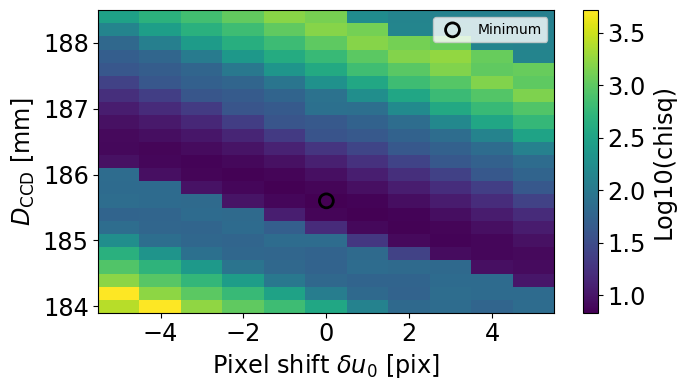

2023-08-28 10:59:32  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.187pix
	D = 185.643 mm (default: DISTANCE2CCD = 186.00 +/- 0.40 mm, -0.9 sigma shift)
2023-08-28 10:59:32  spectractor.extractor.extractor SpectractorRun       INFO   
	  ======================= FFM DECONVOLUTION =============================
2023-08-28 10:59:32  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2023-08-28 10:59:34  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=0.1.
2023-08-28 10:59:34  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start FFM with adjust_spectrogram_position_parameters.
2023-08-28 10:59:50  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=7.5188e+07	initial chisq_red=23220
2023-08-28 11:01:21  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	final cost=1.2495e+07	final chisq_red=38

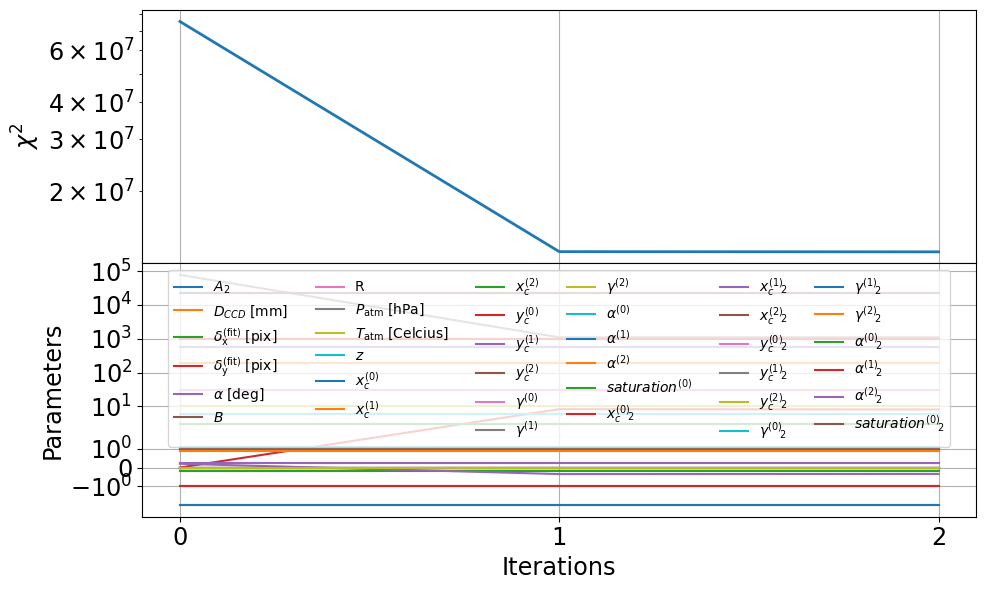

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/extractor/extractor.py:599: RuntimeWarning: All-NaN slice encountered
  norm = np.nanmax(data[:, sub])
/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/extractor/extractor.py:626: RuntimeWarning: Mean of empty slice
  f'mean={np.nanmean(residuals[:, sub]):.3f}\nstd={np.nanstd(residuals[:, sub]):.3f}',
2023-08-28 11:02:20  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:02:22  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_

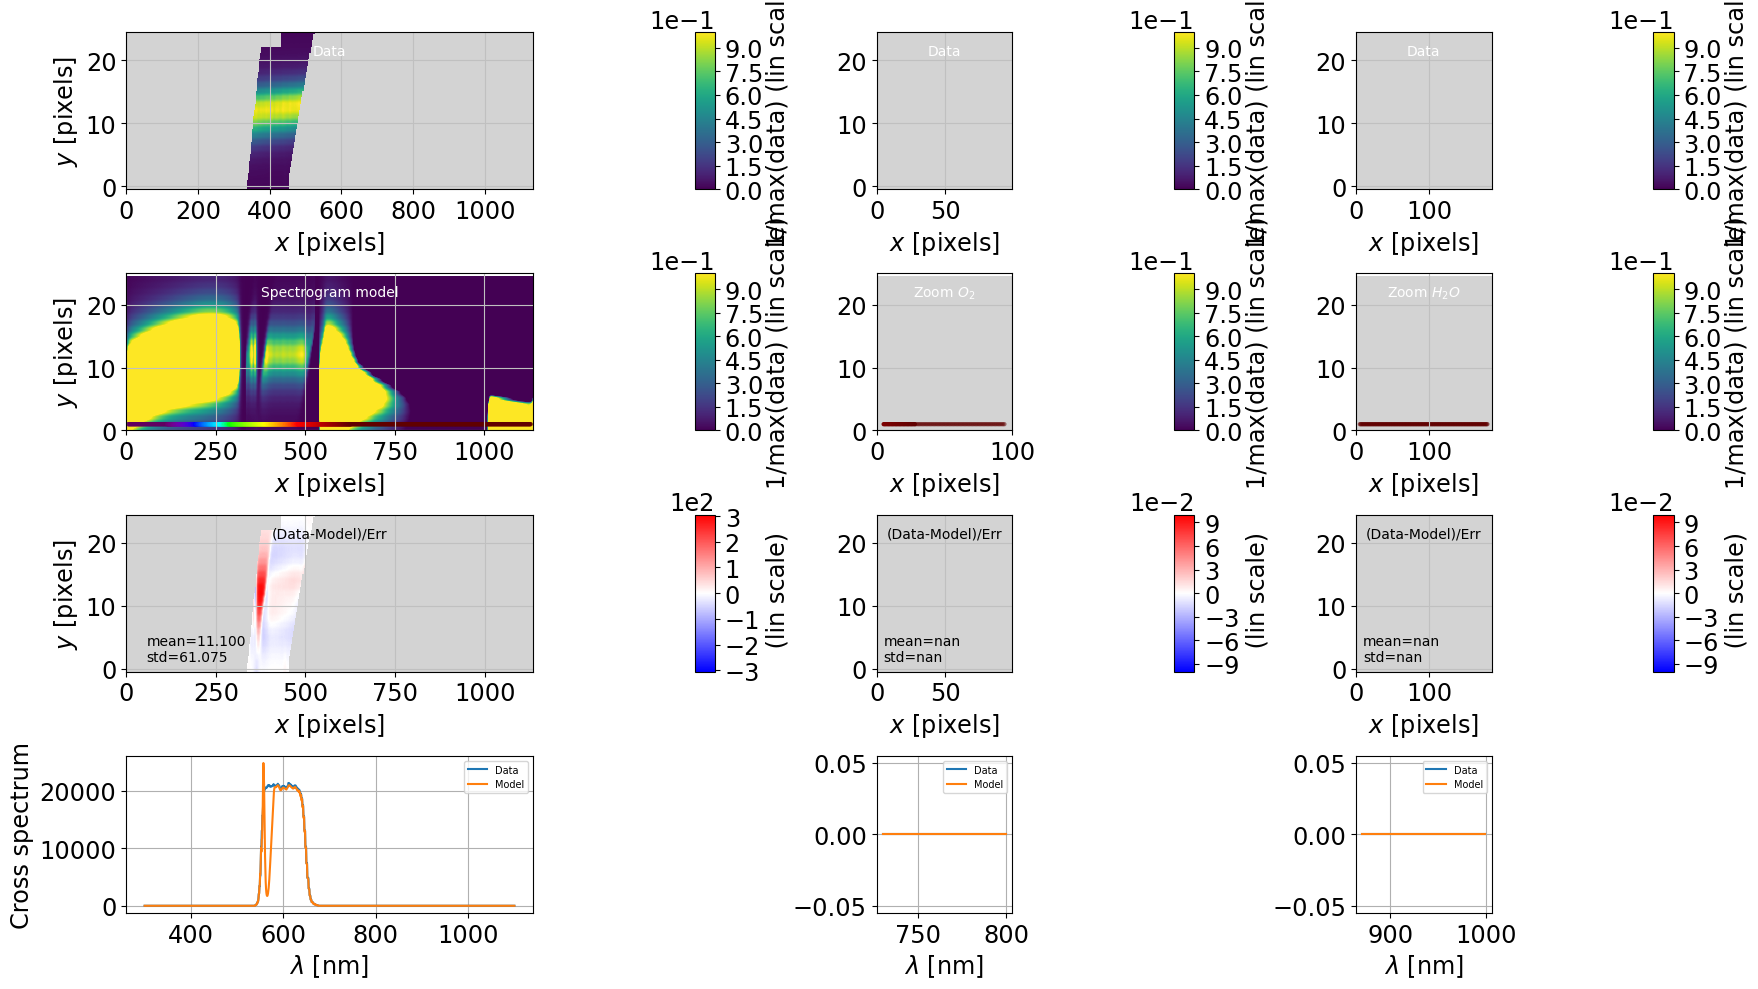

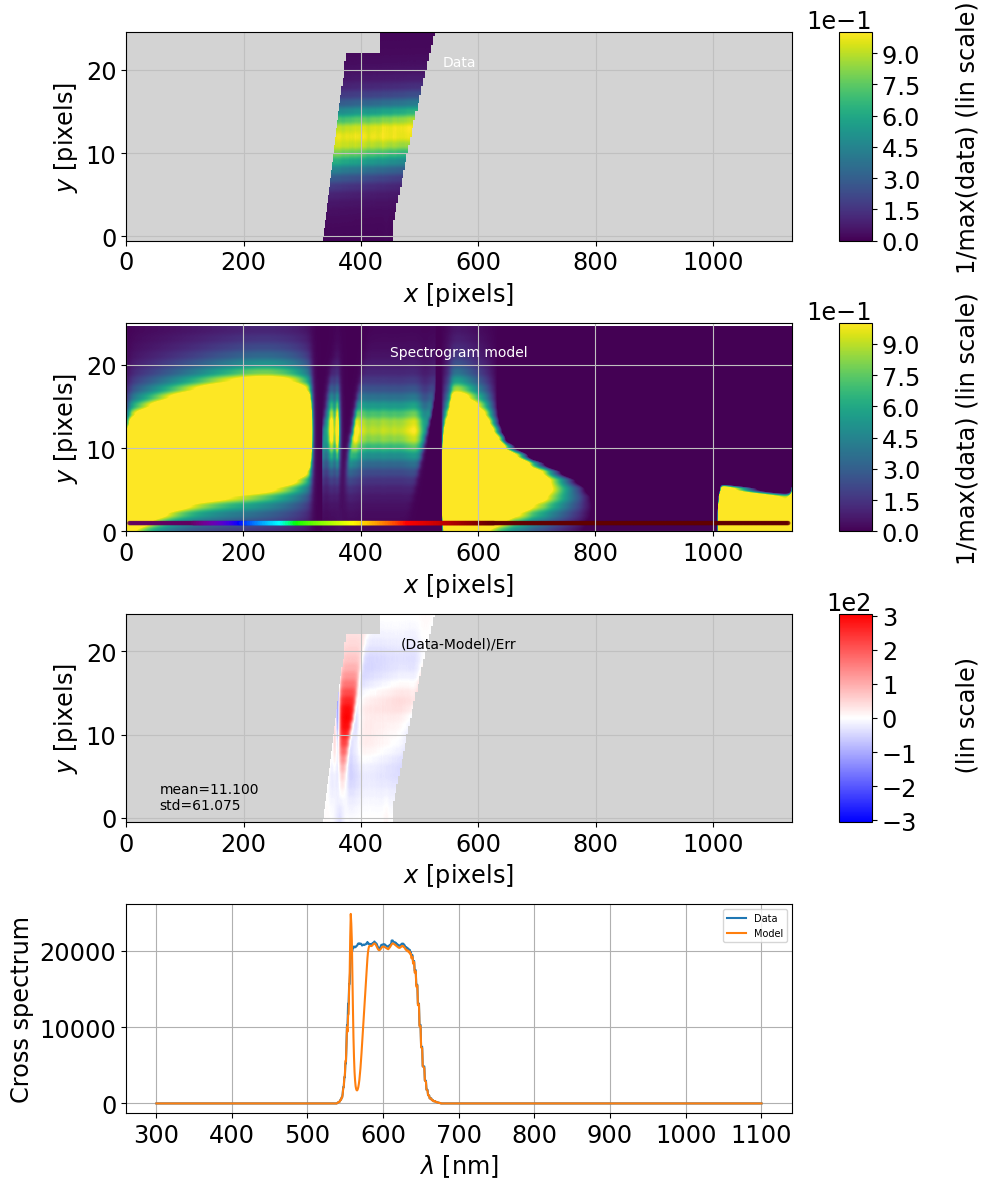

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:470: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


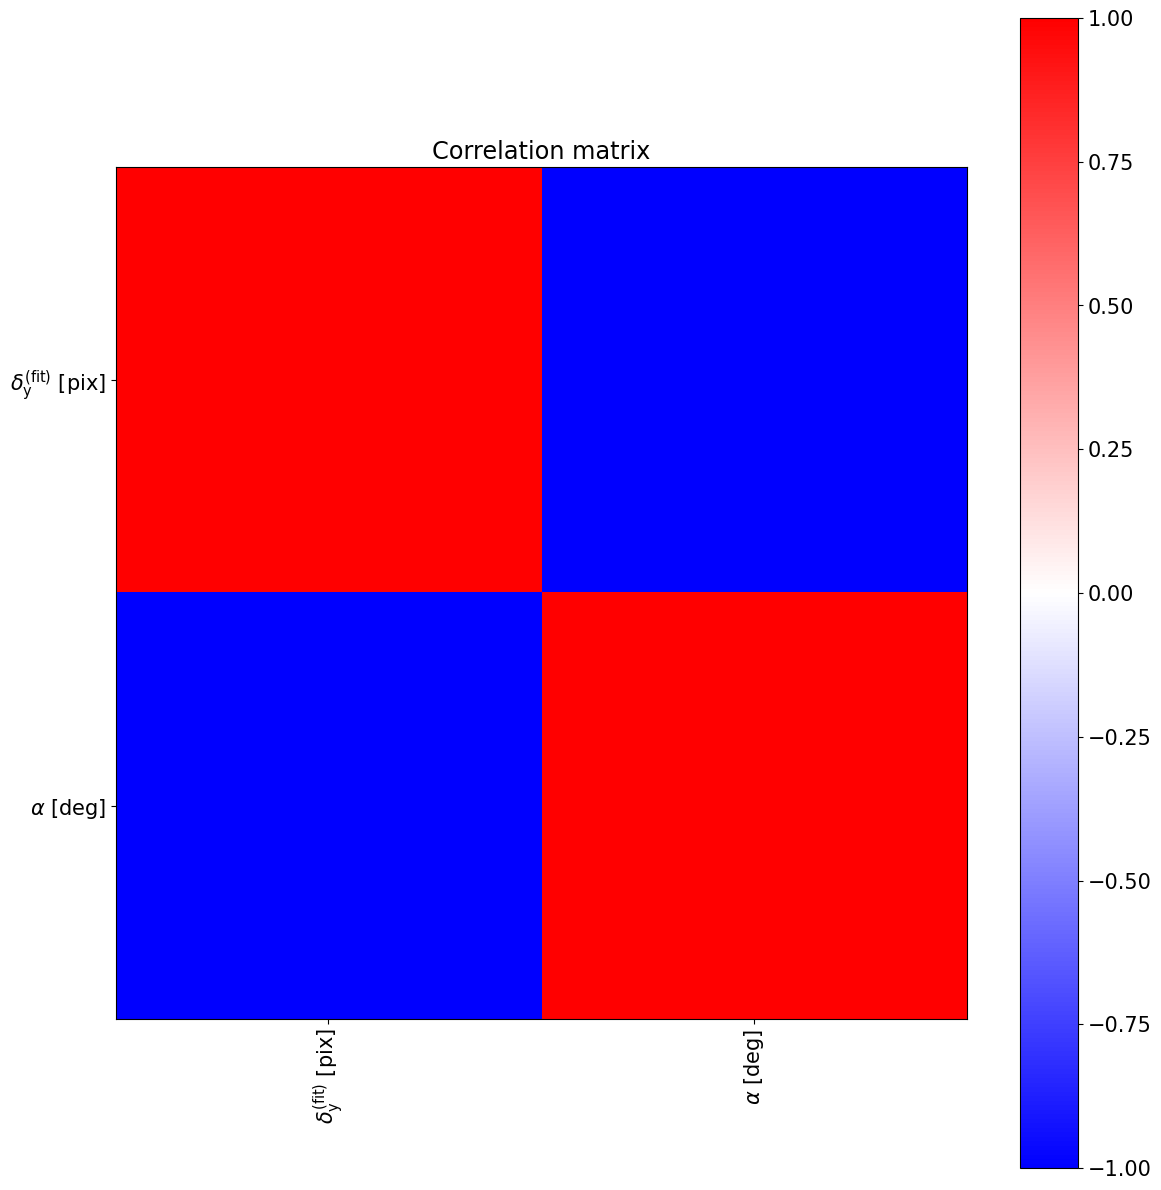

2023-08-28 11:02:25  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2023-08-28 11:02:28  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:02:30  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit_2.pdf.


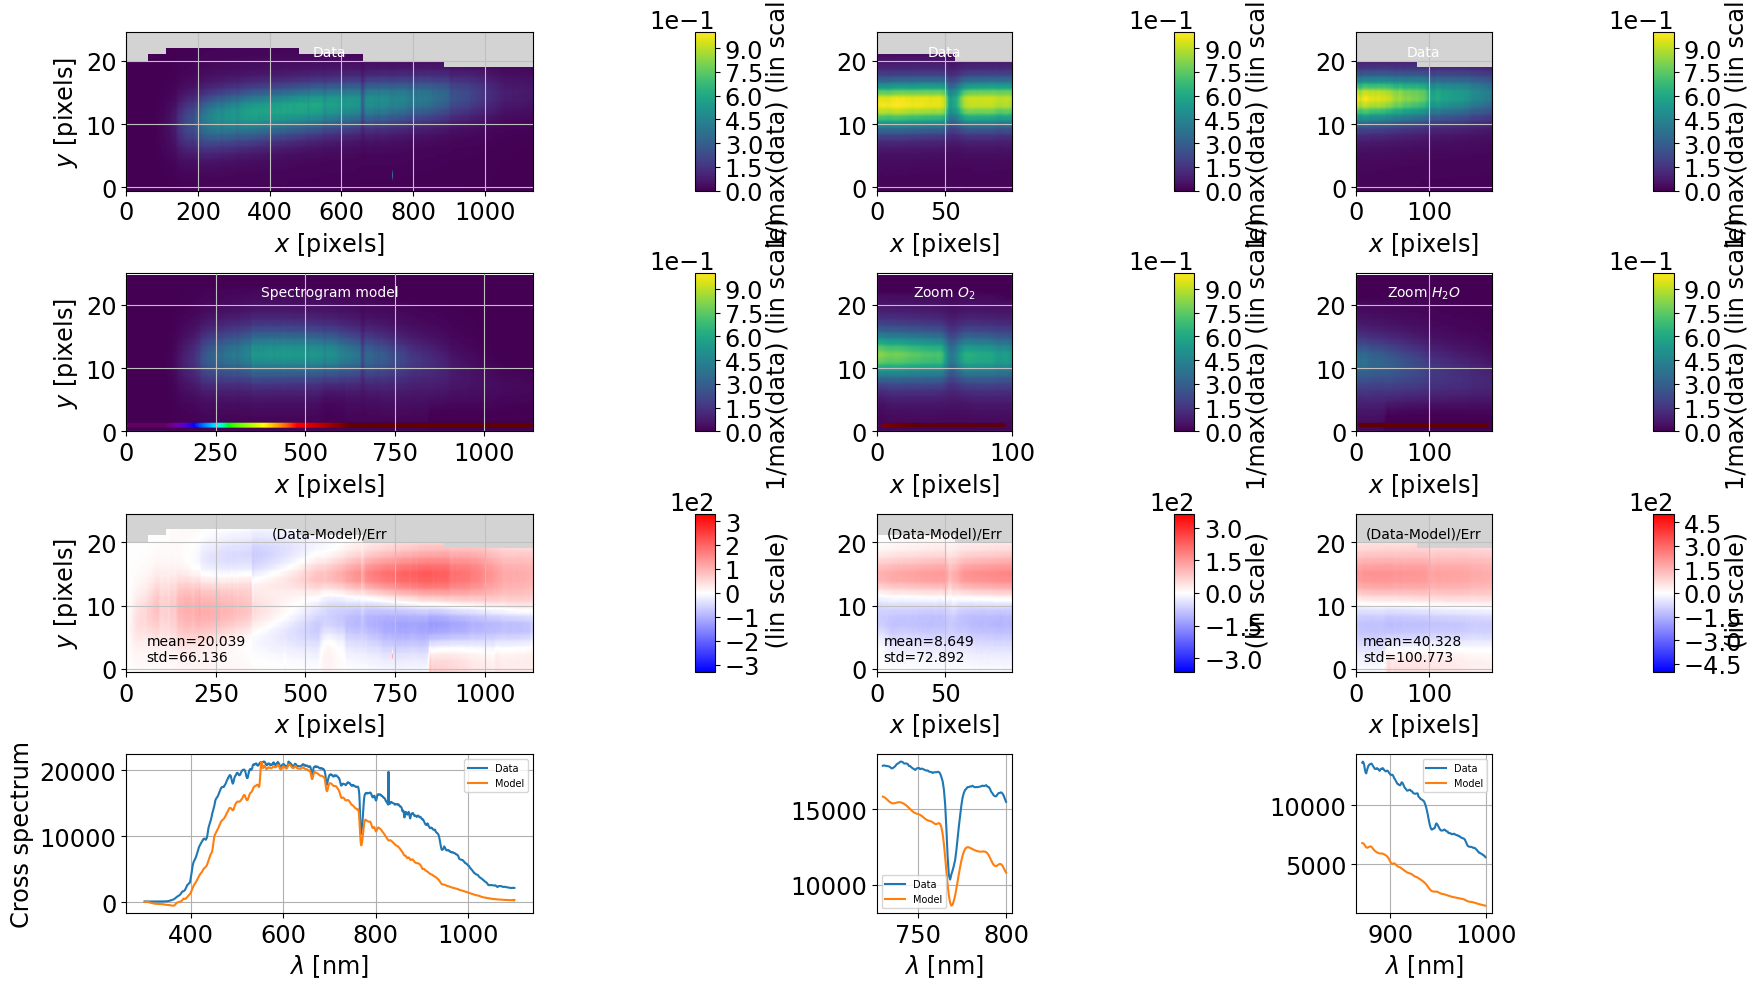

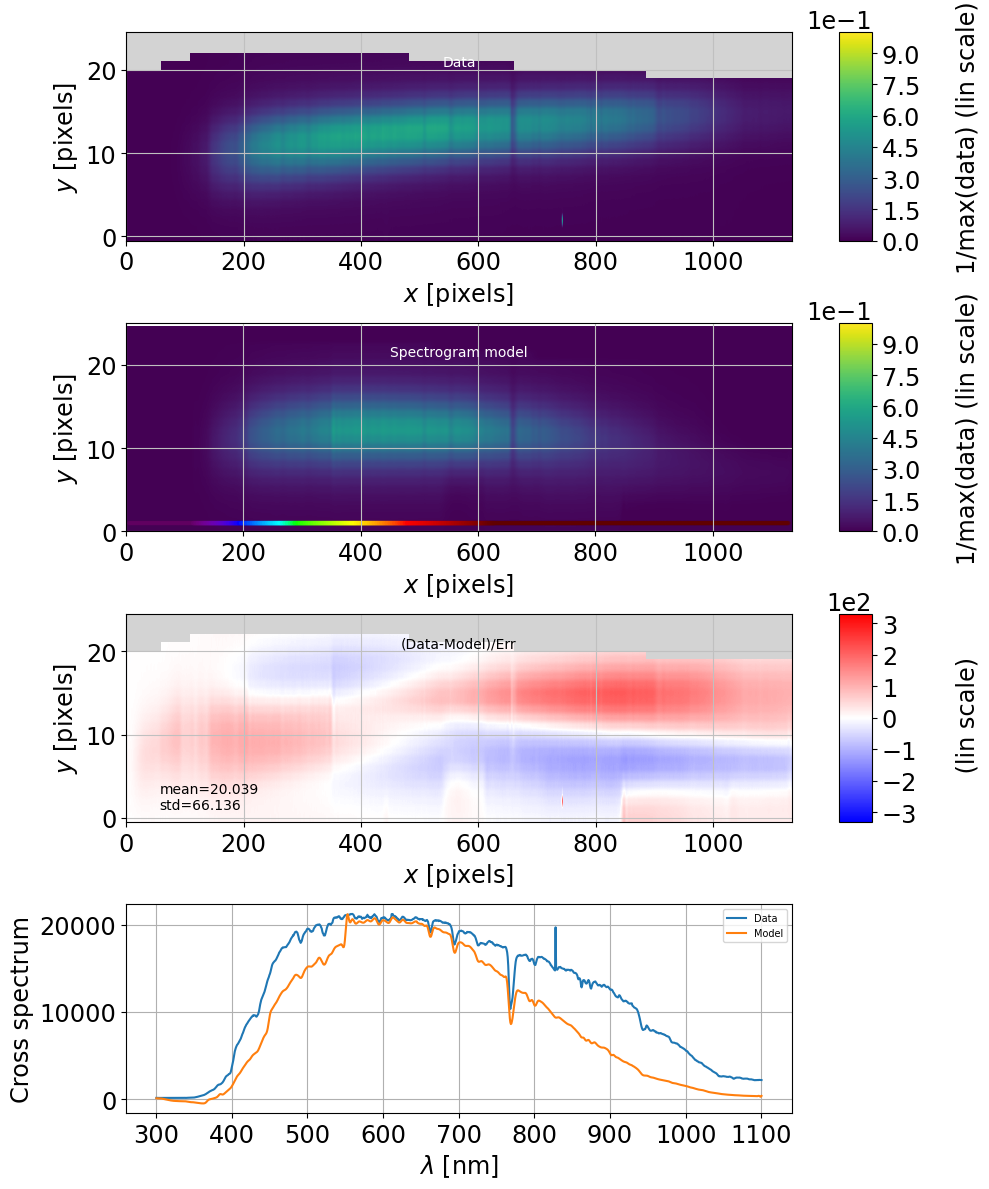

2023-08-28 11:02:33  spectractor.extractor.extractor run_ffm_minimisation INFO   	Start guess:
	A2: 1.0 (fixed=True)
	D_CCD [mm]: 185.64342892629176 (fixed=True)
	shift_x [pix]: -0.18655016461008103 (fixed=True)
	shift_y [pix]: 8.071106008150604 (fixed=True)
	angle [deg]: -0.34076079283372523 (fixed=True)
	B: 1.0 (fixed=True)
	R: 30.085673788950288 (fixed=True)
	P [hPa]: 1100.0 (fixed=True)
	T [Celsius]: 10.32499980926514 (fixed=True)
	z: 1.111734582937876 (fixed=True)
	x_c_0: 986.6344580474031 (fixed=True)
	x_c_1: 567.496542595796 (fixed=True)
	x_c_2: 5.957362419100149e-13 (fixed=True)
	y_c_0: 0.0 (fixed=False)
	y_c_1: 0.0 (fixed=False)
	y_c_2: 0.0 (fixed=False)
	gamma_0: 6.1043298777066 (fixed=False)
	gamma_1: -2.018890569865631 (fixed=False)
	gamma_2: 0.9022889260739181 (fixed=False)
	alpha_0: 3.043249036417331 (fixed=False)
	alpha_1: -0.9954029449213032 (fixed=False)
	alpha_2: 0.22832306805212907 (fixed=False)
	saturation_0: 22666.66666666668 (fixed=True)
	x_c_0_2: 986.634458047403

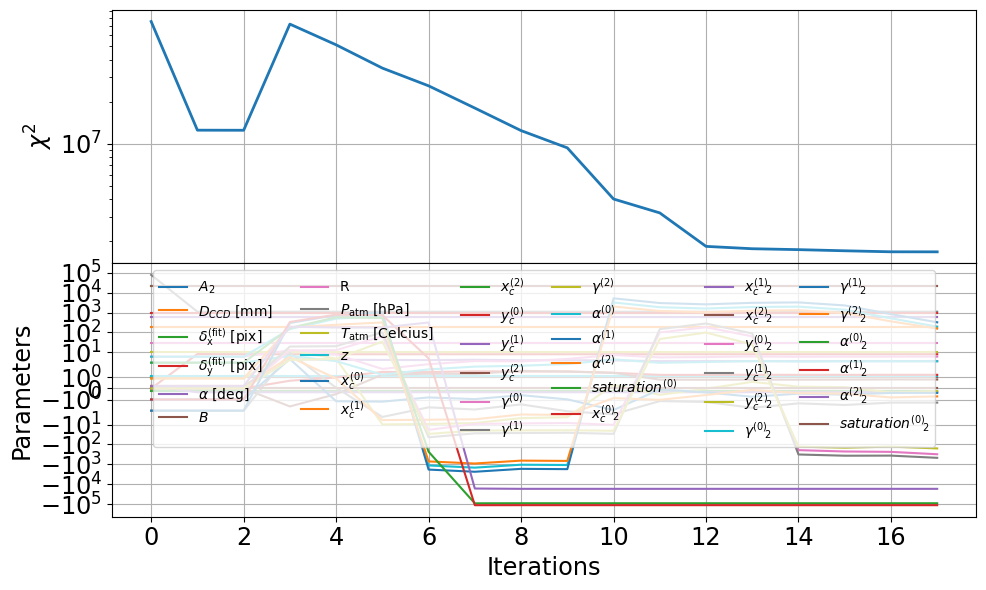

2023-08-28 11:06:53  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:06:55  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit_2.pdf.


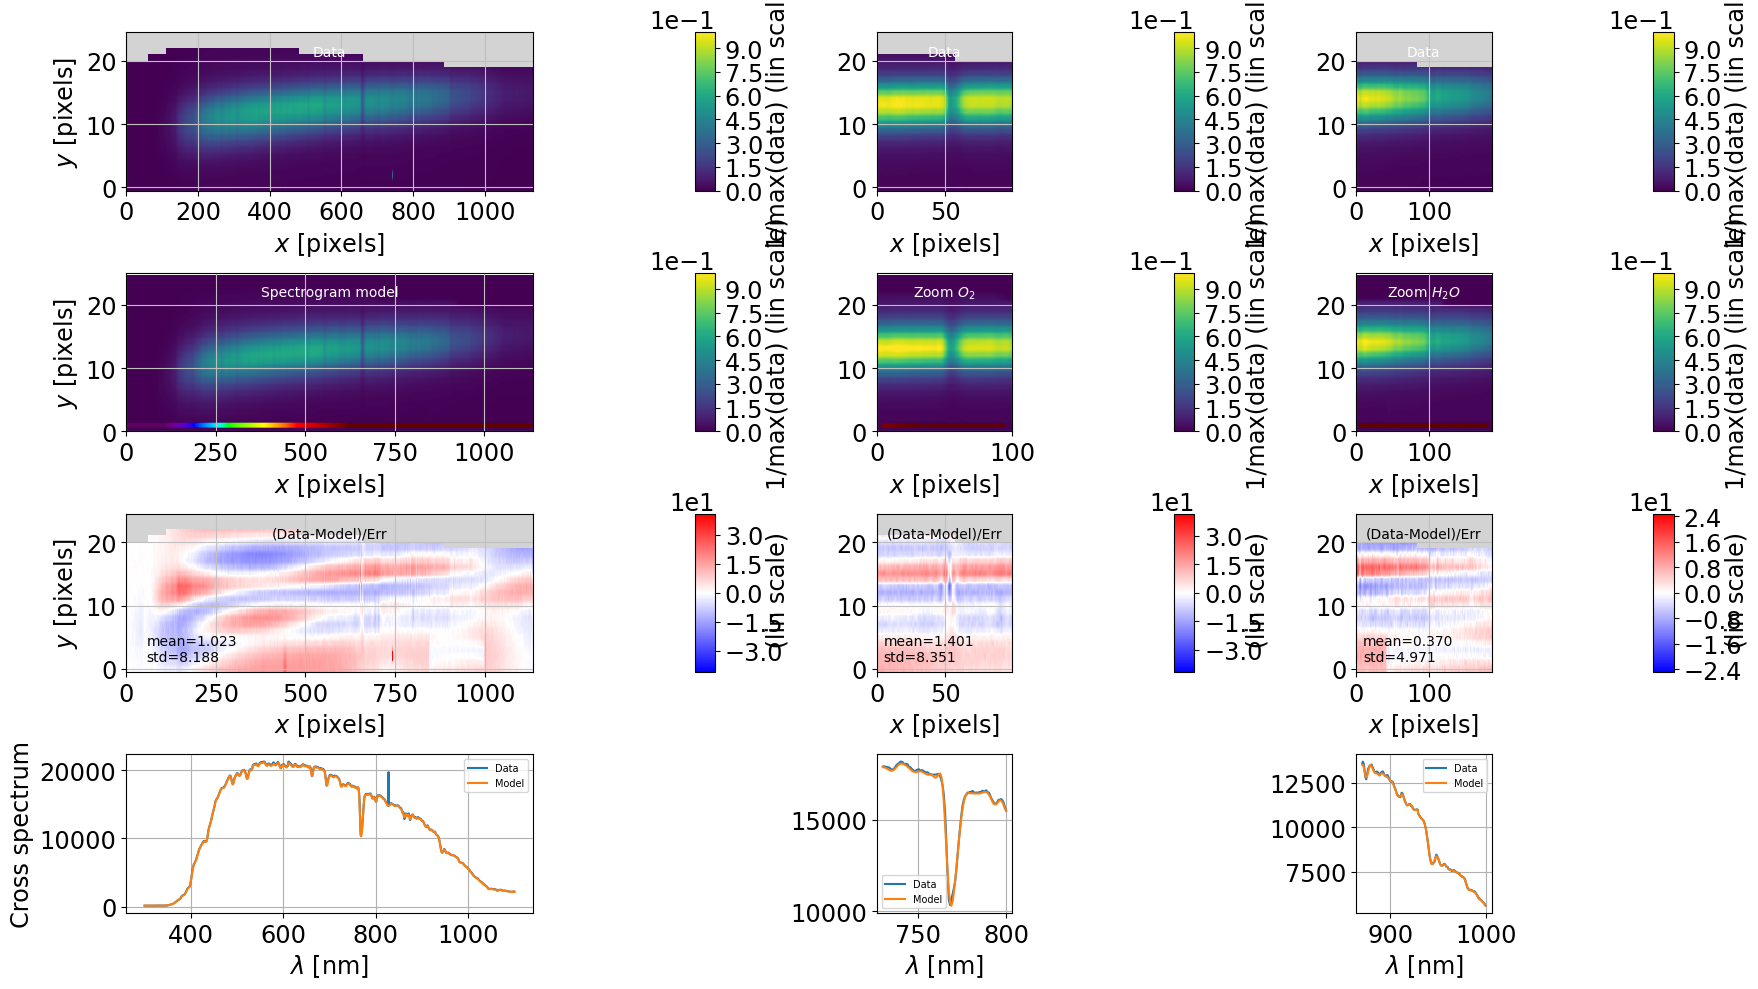

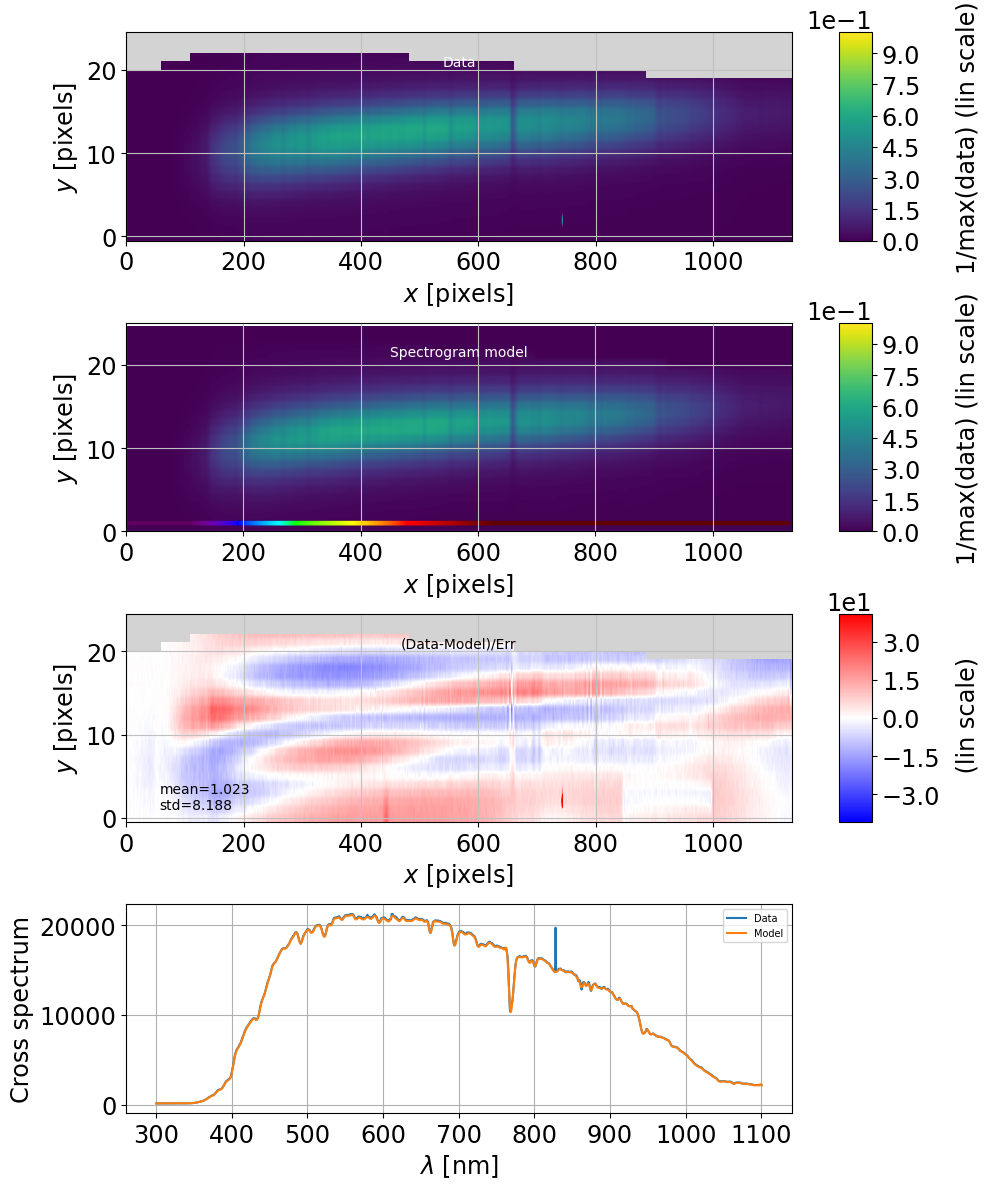

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:470: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


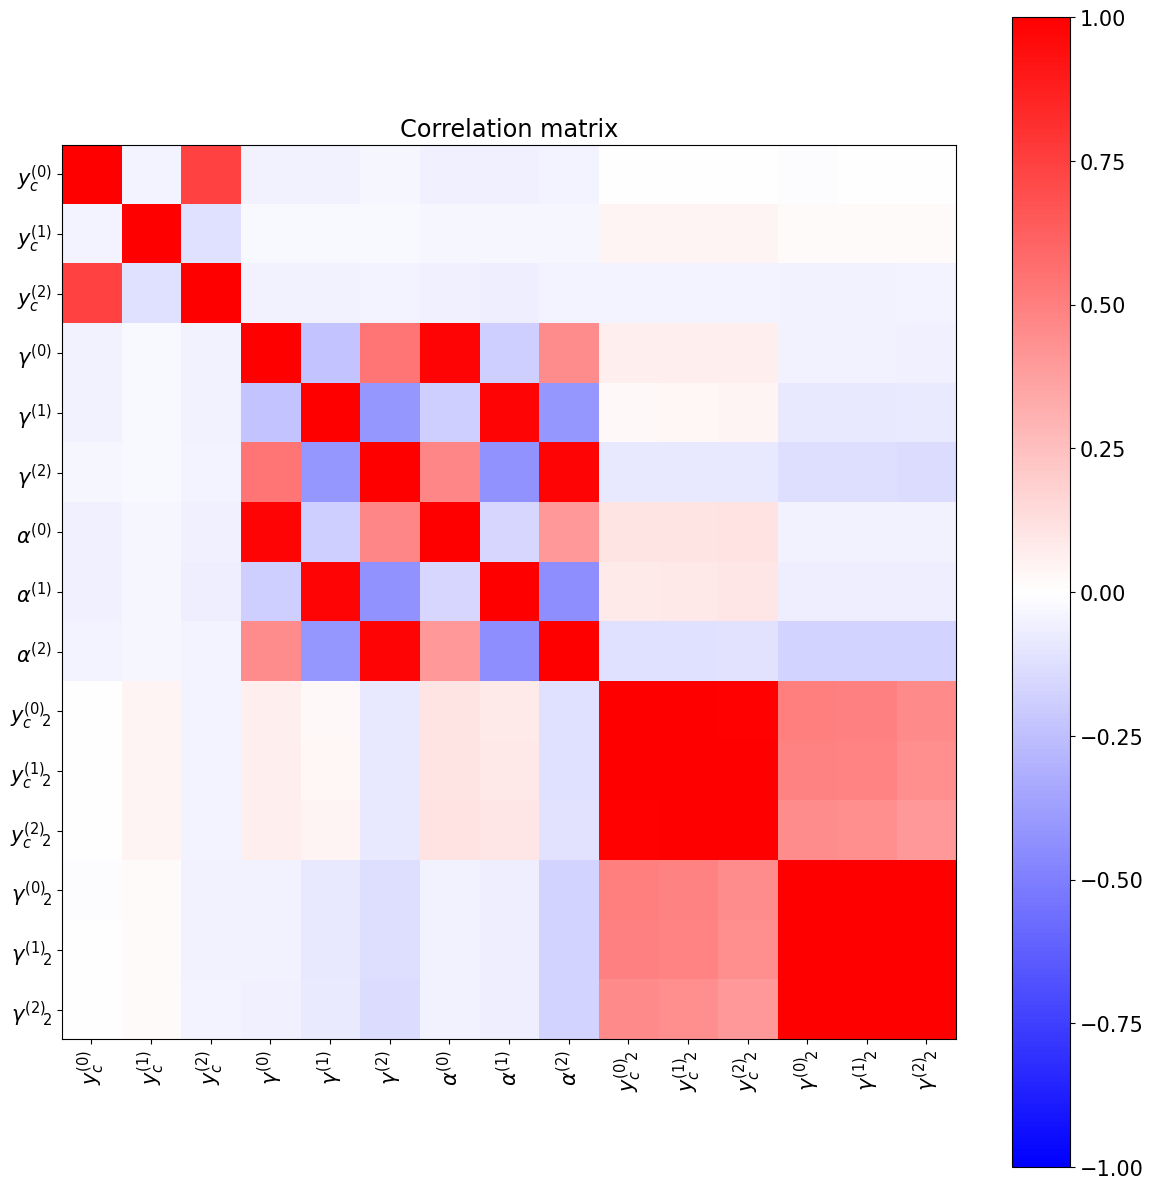

2023-08-28 11:07:00  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:07:02  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit_2.pdf.


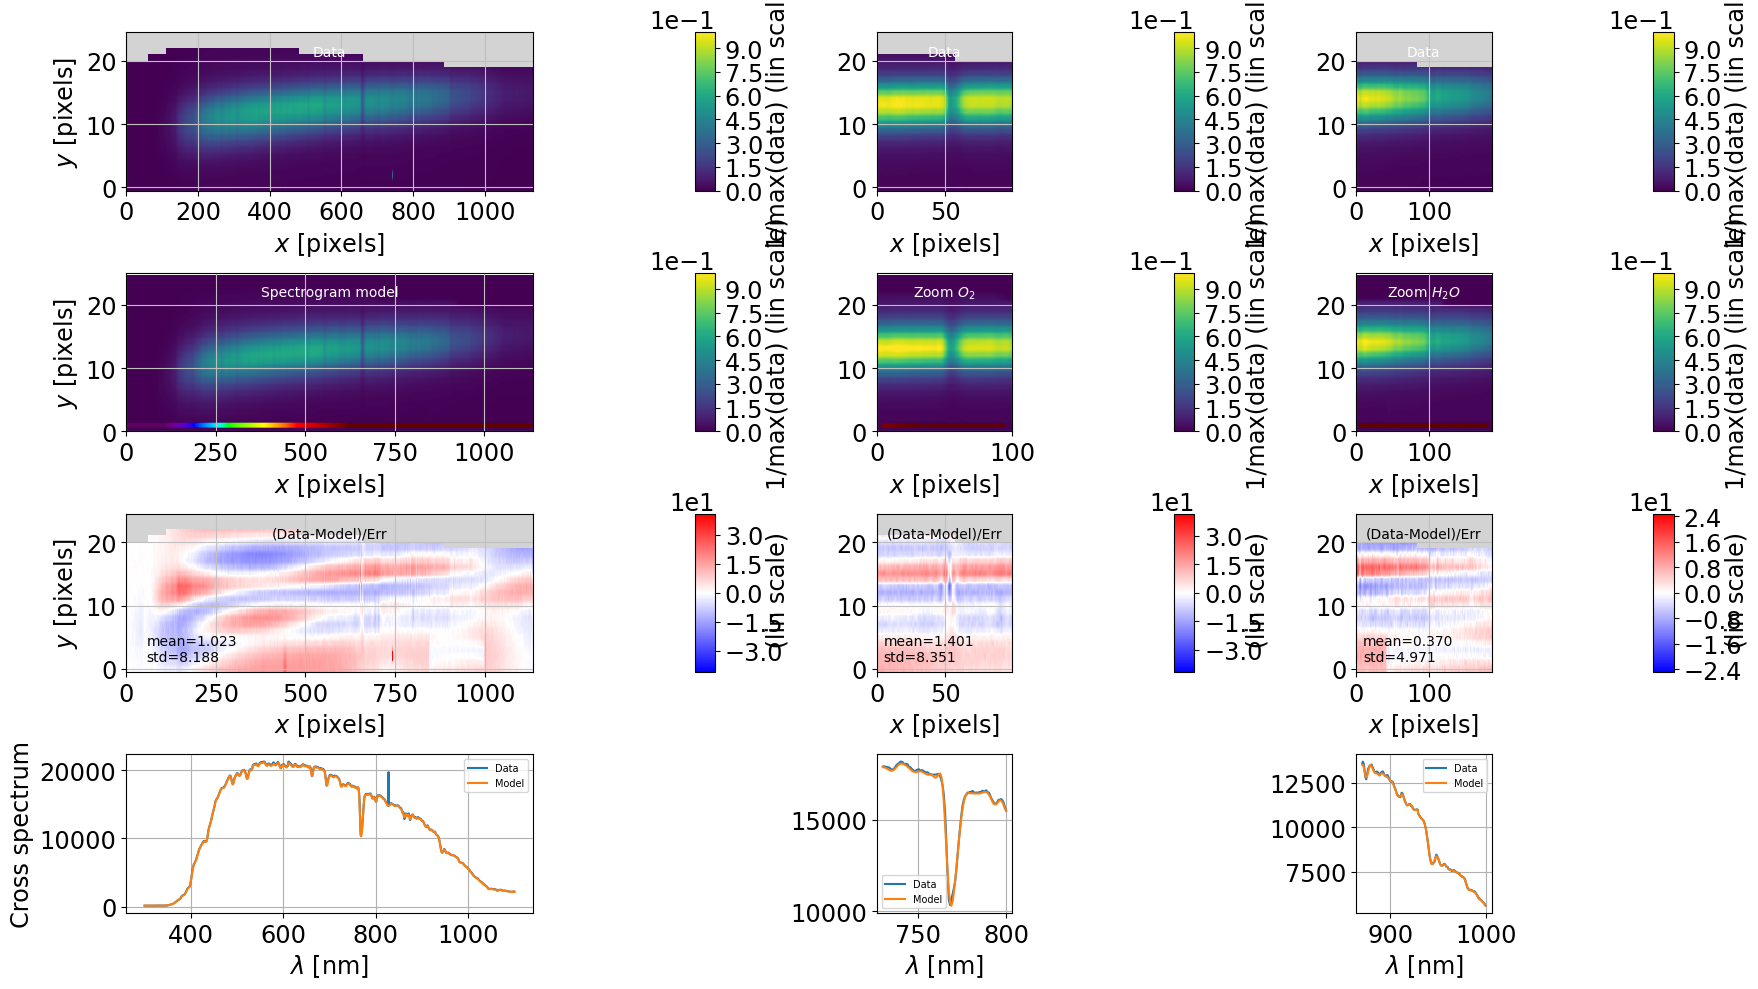

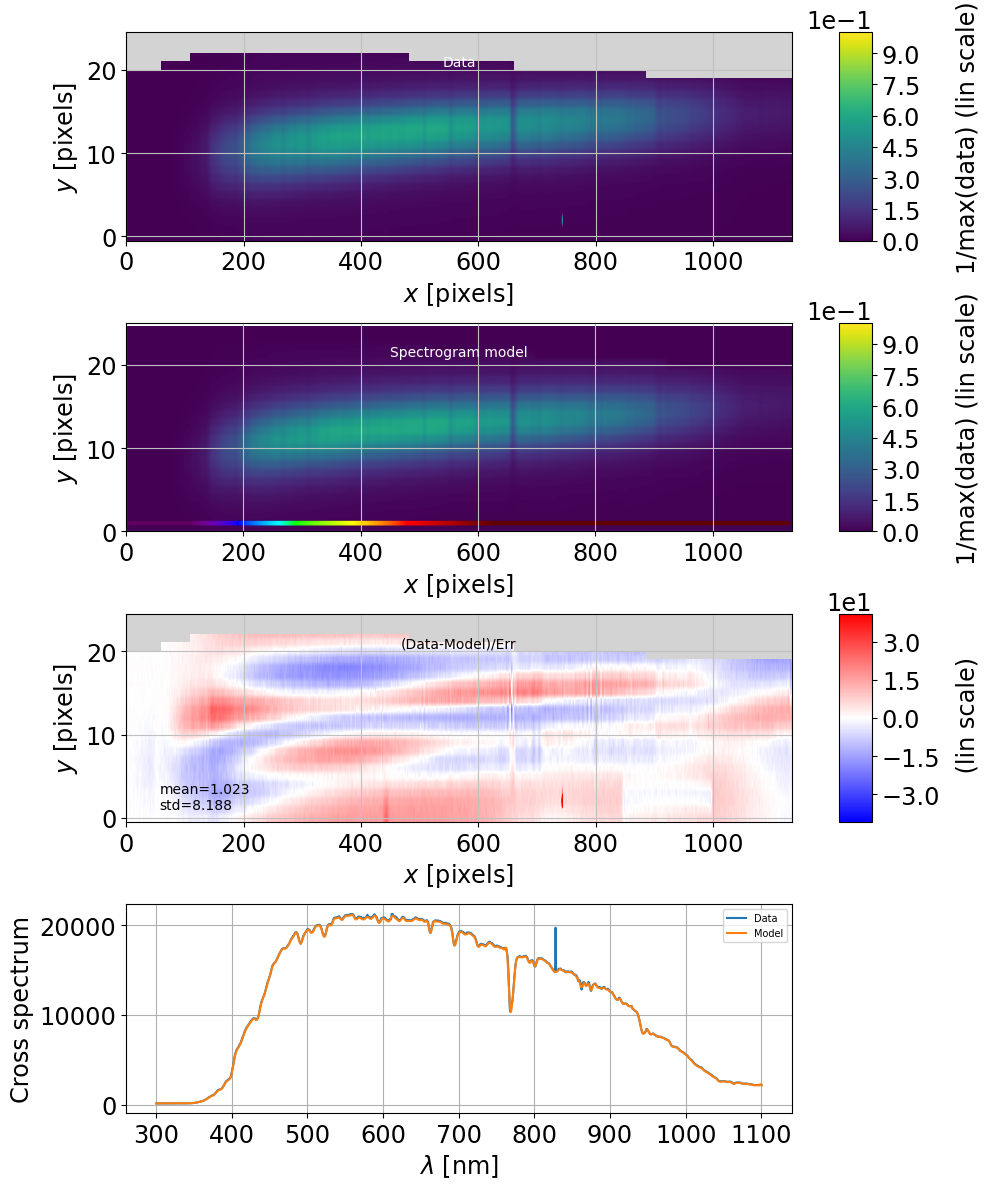

2023-08-28 11:07:05  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Mean FWHM: 6.152808198762862 pixels (weighted with spectrum amplitude)


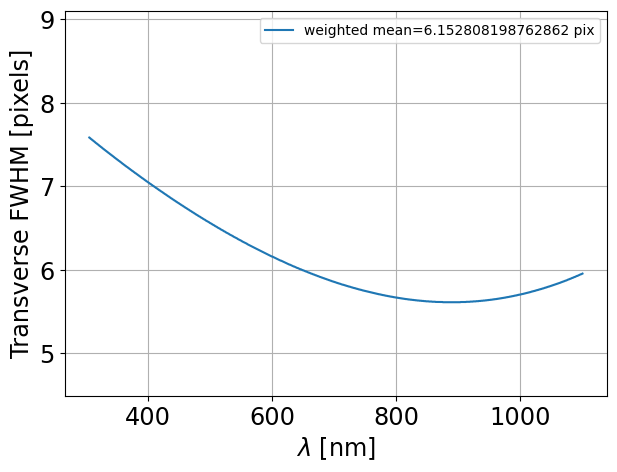

2023-08-28 11:07:05  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start regularization parameter only.
/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:1772: OptimizeWarning: Unknown solver options: ftol
  result = optimize.minimize(nll, fit_workspace.params.values, method=minimizer_method,


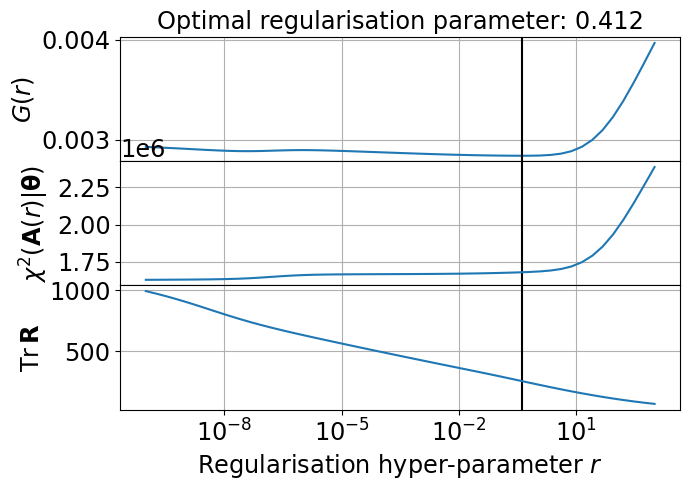

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:2029: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


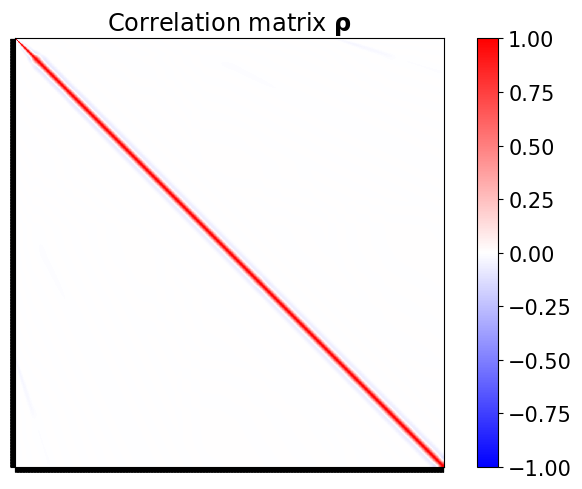

2023-08-28 11:07:31  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.41157892167922105
	Tr(R) = 256.18123662048936
	N_params = 1136
	N_data = 24588 (without mask and outliers)
2023-08-28 11:07:33  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:07:35  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit_2.pdf.


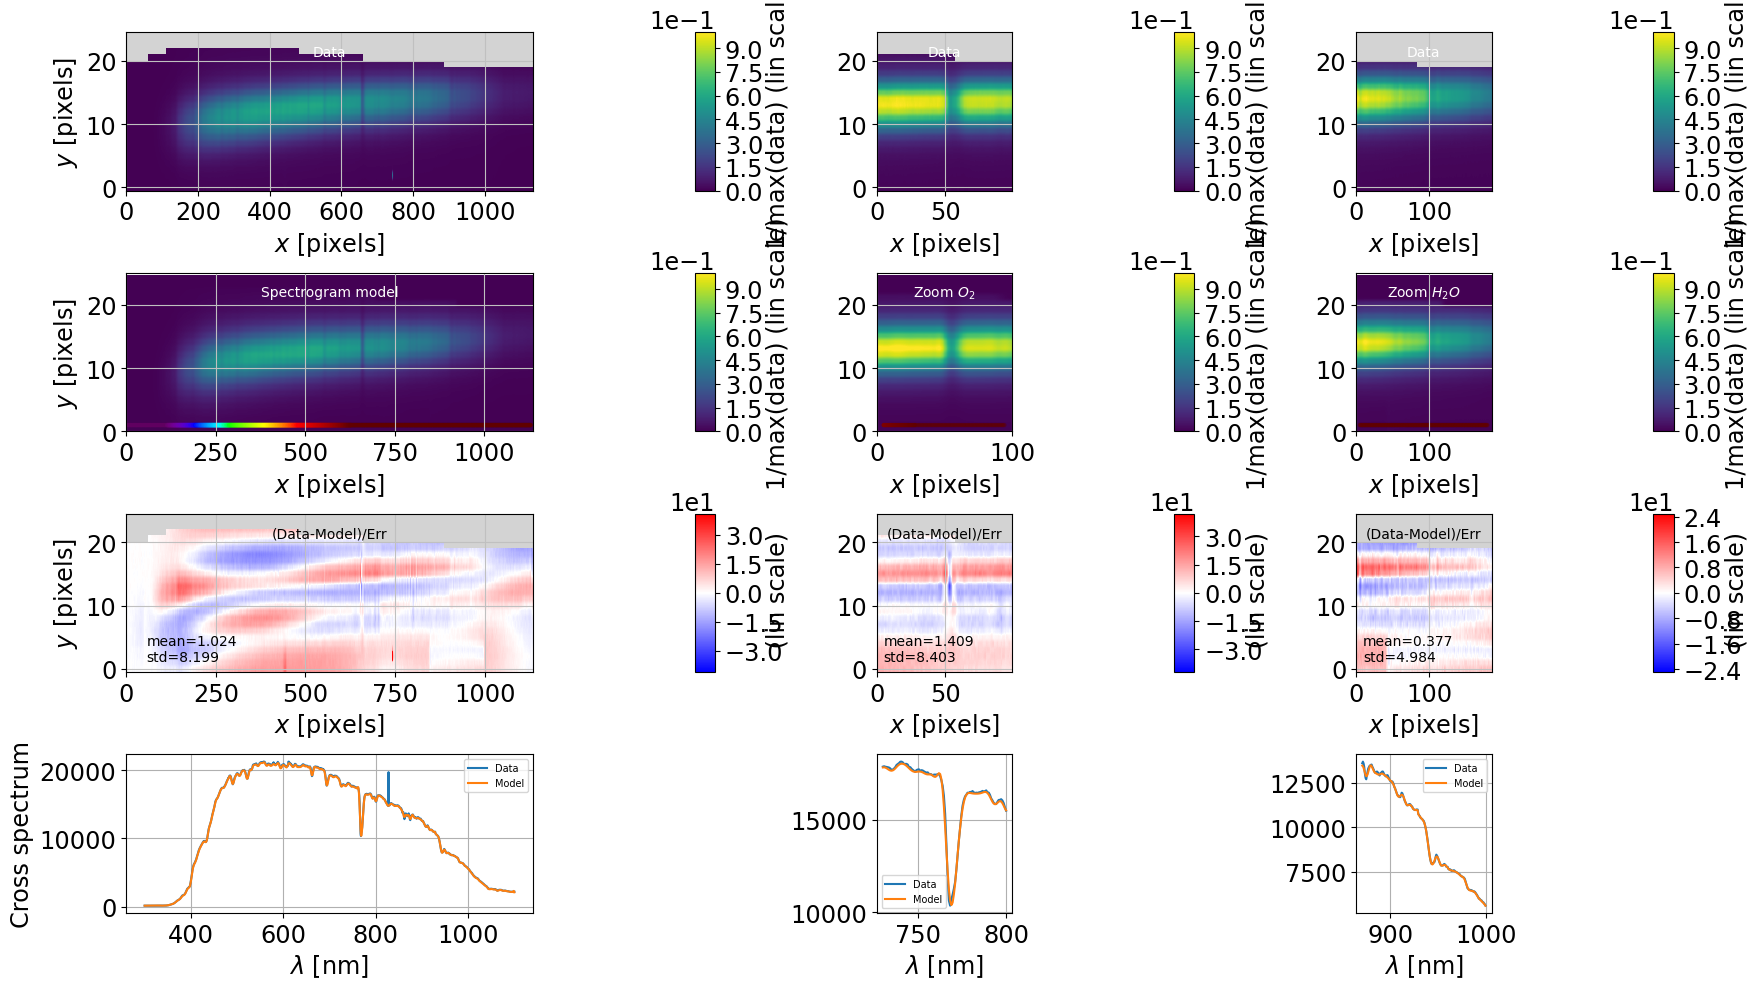

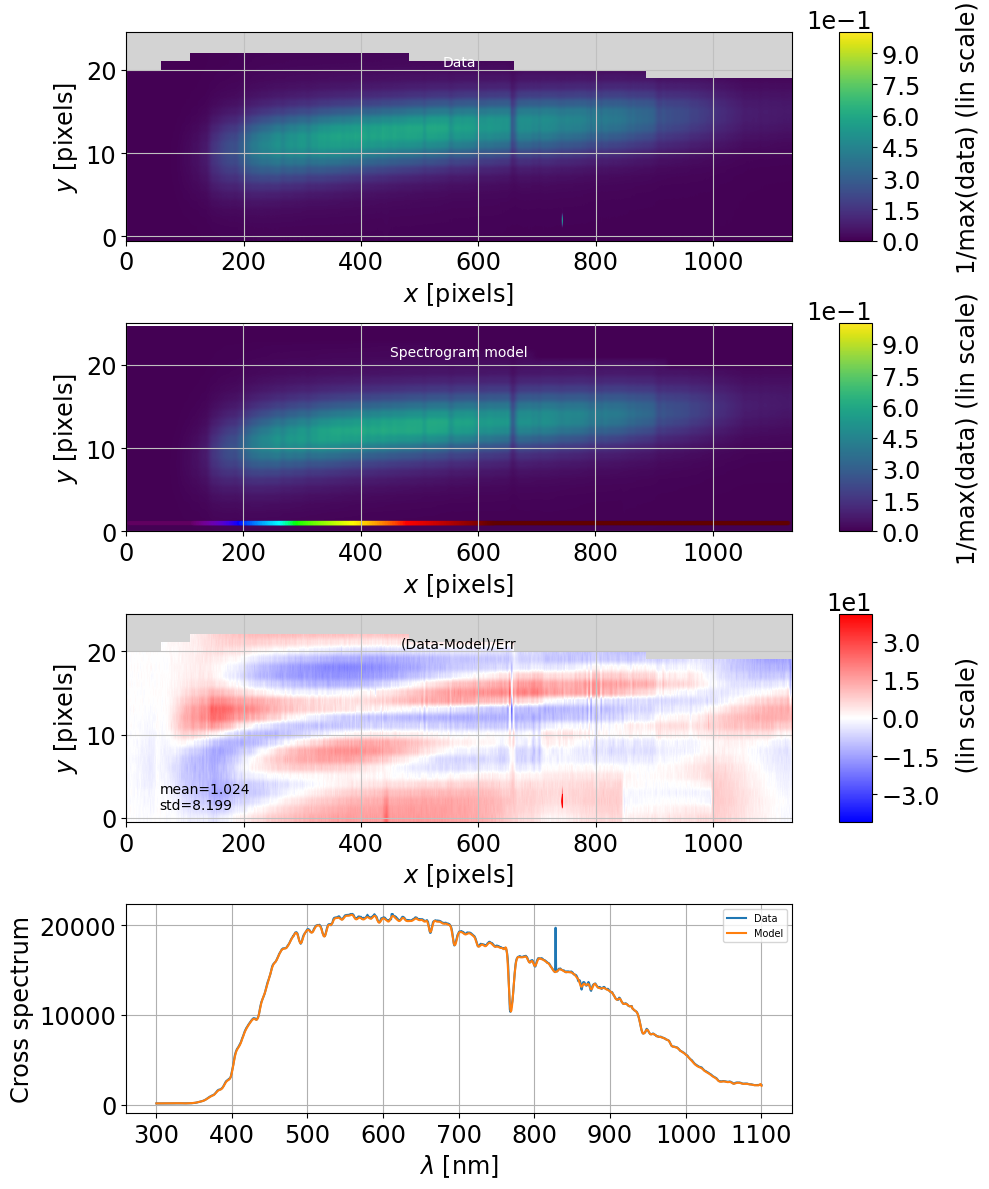

2023-08-28 11:07:37  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start run_minimisation_sigma_clipping with sigma=100.
2023-08-28 11:07:37  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2023-08-28 11:07:39  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Sigma-clipping step 0/3 (sigma=100)
2023-08-28 11:07:42  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=1.4027e+06	initial chisq_red=62.03
2023-08-28 11:08:37  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	final cost=1.3693e+06	final chisq_red=60.549 	computed in 58.45s
2023-08-28 11:09:42  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1:	final cost=1.3603e+06	final chisq_red=60.154 	computed in 64.54s
2023-08-28 11:10:43  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=2:	final cost=1.3566e+06	final chisq_red=59.989 	computed in 61.12s
2023-08-28 11:11:41  sp

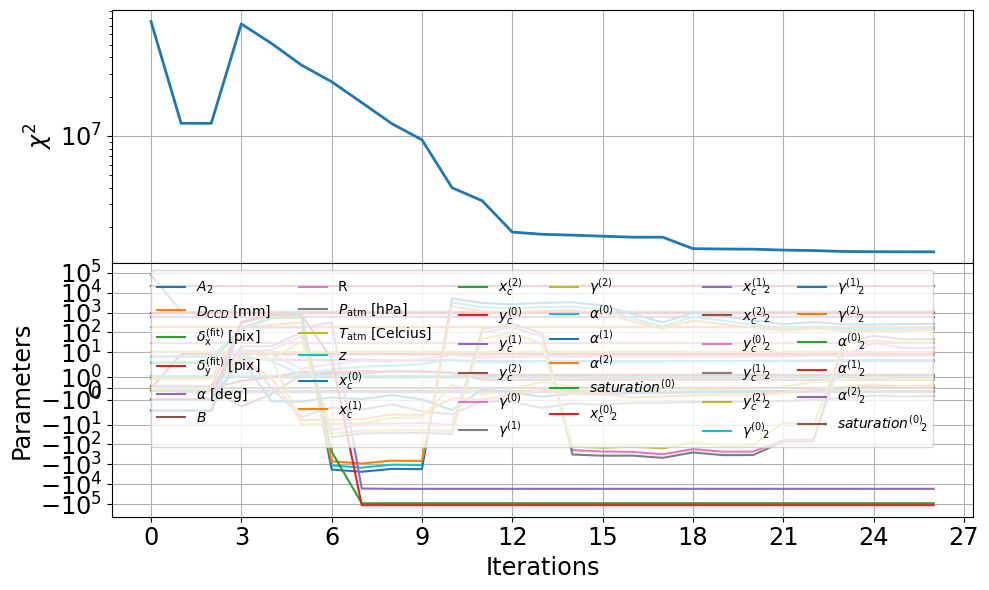

2023-08-28 11:16:10  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit.pdf.
2023-08-28 11:16:12  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230720_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_1/ffm_bestfit_2.pdf.


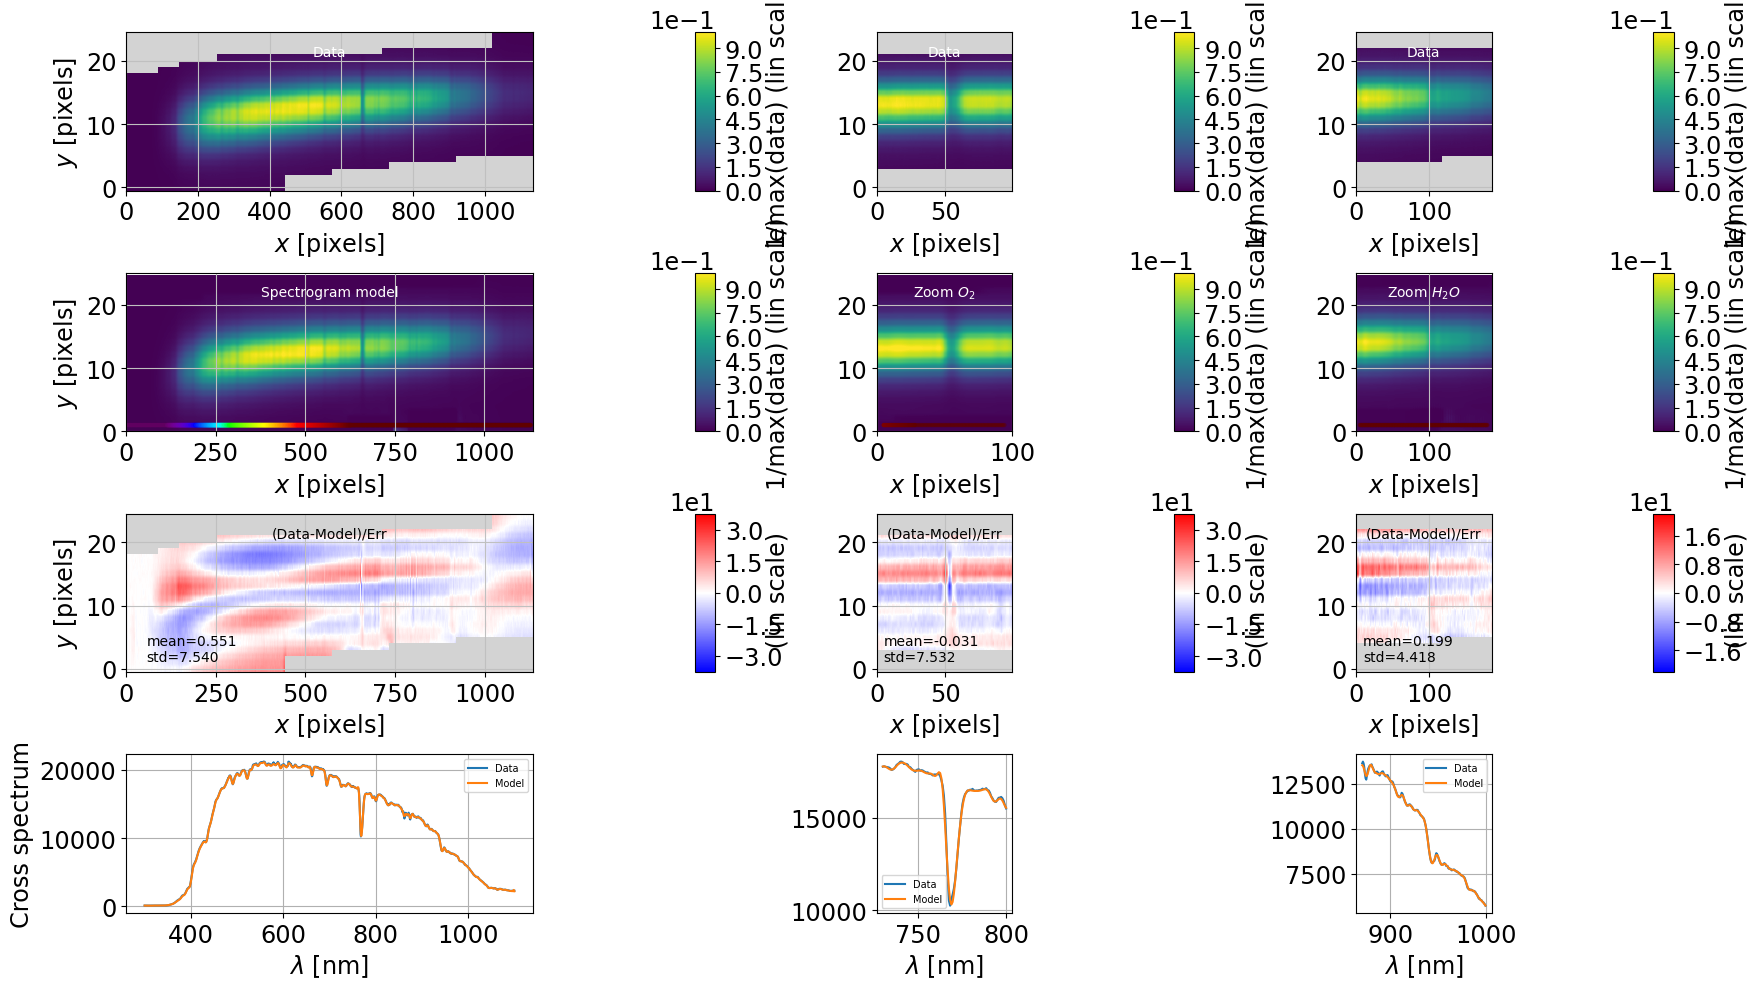

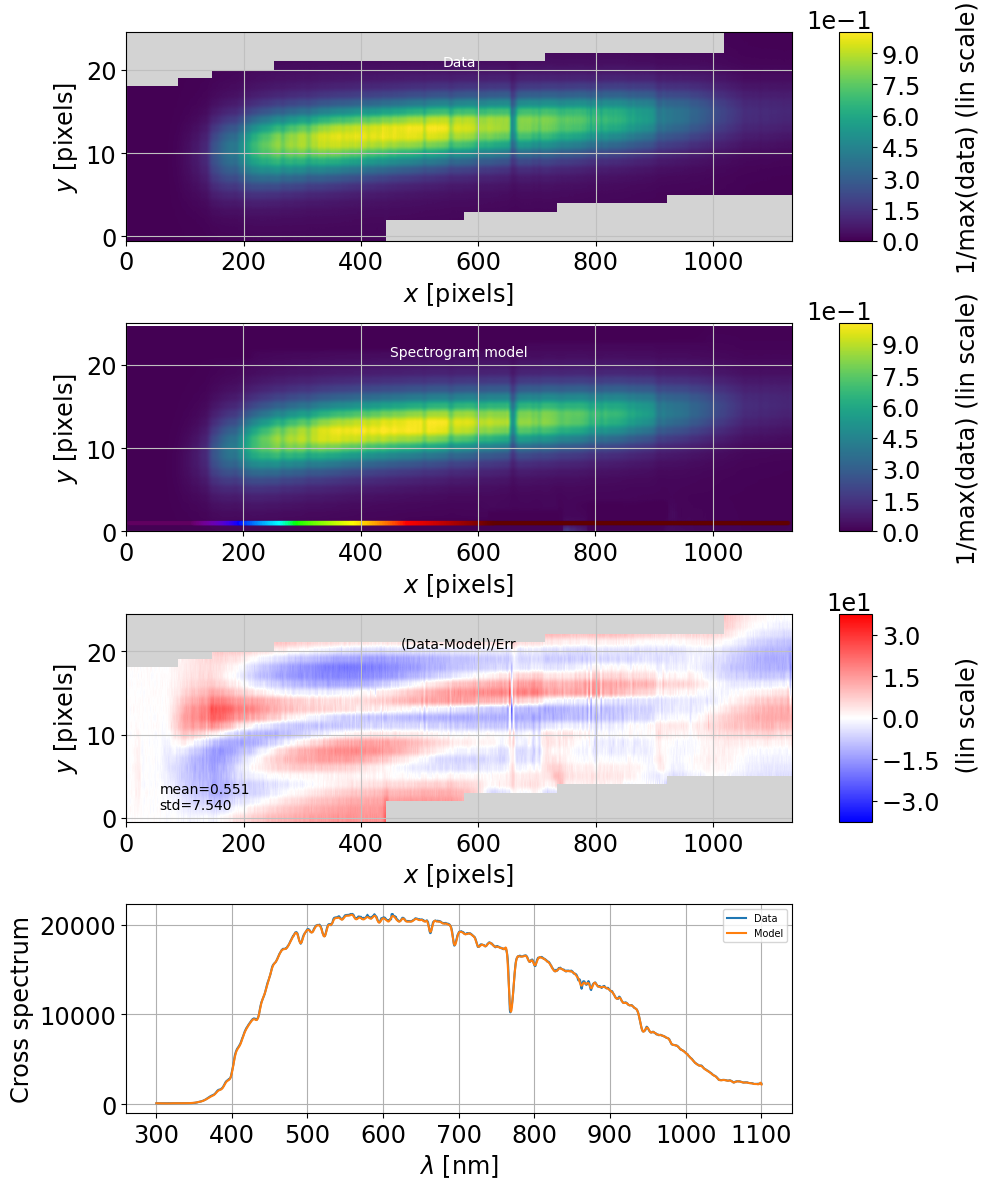

/Users/dagoret/opt/anaconda3/envs/spectractor/lib/python3.9/site-packages/spectractor/fit/fitter.py:470: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


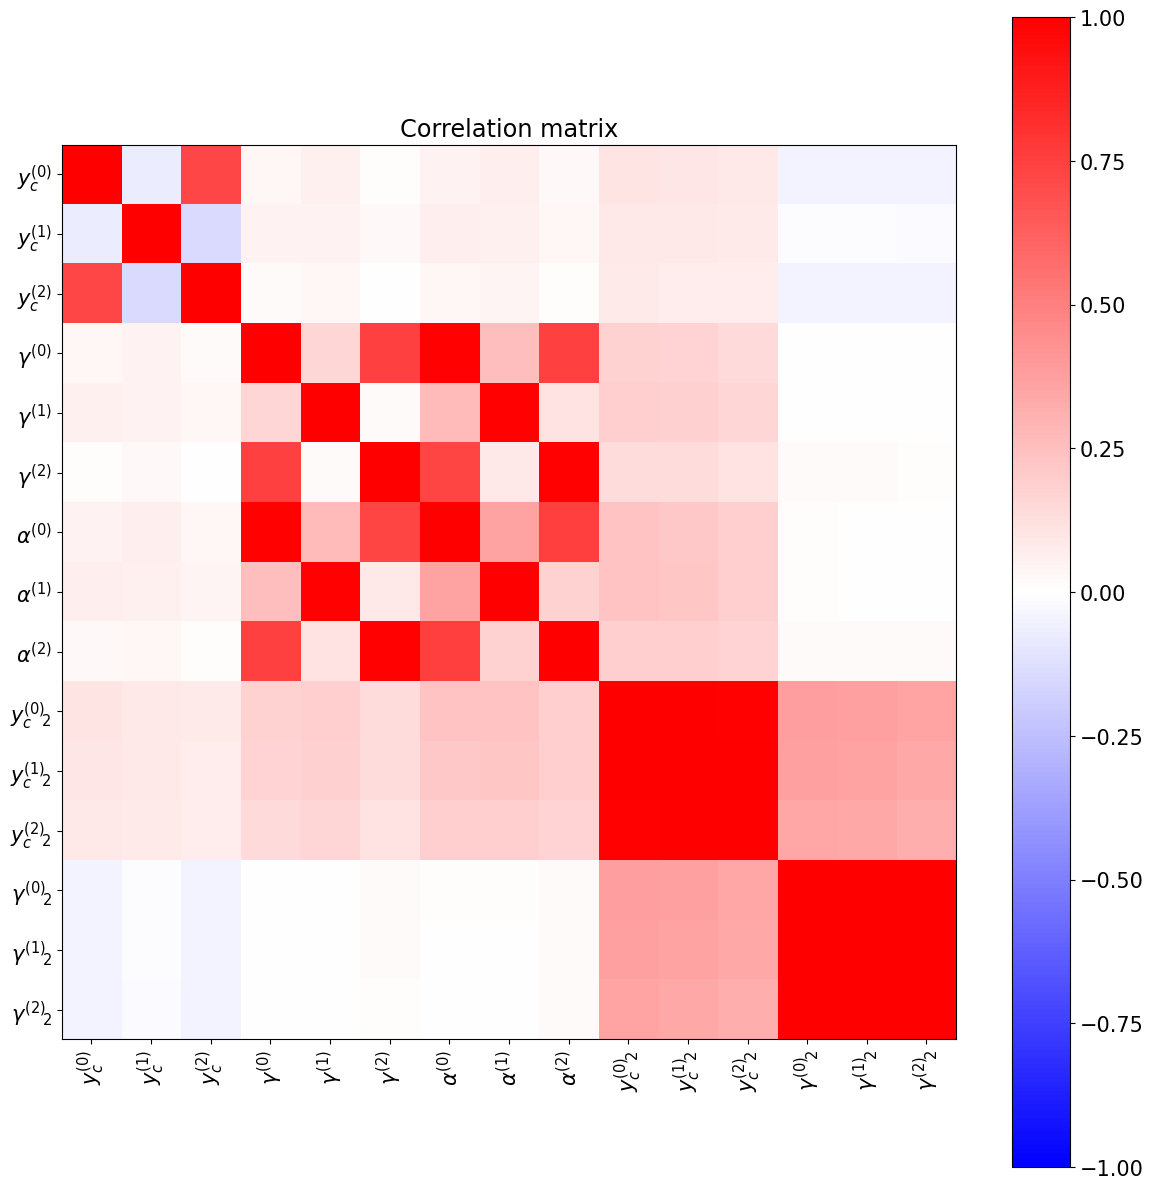

2023-08-28 11:16:16  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 40 / 22614 data points (0.18%) at more than 100-sigma from best-fit model.
2023-08-28 11:16:16  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Sigma-clipping step 1/3 (sigma=100)
2023-08-28 11:16:19  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=1.294e+06	initial chisq_red=57.323


In [ ]:
%matplotlib inline
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)

In [ ]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

fig = plt.figure(figsize=[12, 6])
ax = plt.gca()
spectrum.plot_spectrum(ax=ax,force_lines=True) 
all_figs = [fig]
# gerate a multipage pdf:
multipage_pdf_file = f"spectrum_final_{target}_{DATE}_{the_num}_{configdir}.pdf"
fullfn_multipage_pdf_file = os.path.join(output_figures,multipage_pdf_file)
with PdfPages(fullfn_multipage_pdf_file) as pdf:
    for the_fig in all_figs:
        pdf.savefig(fig)
        plt.close()


# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [ ]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [ ]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("******************************** SUCCESS ********************************************")

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
output_directory